# FIN 554 : Strategy Project (Sovereign Bonds Analysis)
## Macro-indicators plus momentum indicators based Machine learning-aided modeling of fixed income instruments
### Group members: Yadvesh, Krish, Gaurav, Ganesh

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBRegressor
from scipy.stats import stats
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
import xgboost as xgb
import itertools
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from arch import arch_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 1) Importing the Sovereign Bonds Data

### 1.1) Treasury Bonds Data

In [163]:
import os
current_dir = os.getcwd()
sovereign_folder_path = os.path.join(current_dir, "Australia_Bond_Data")
print(sovereign_folder_path)

d:\_IncrementalMaybe\Strategy_Project\fin554_algo_trading_strategy_fall_2024_group_05\Australia_Bond_Data


In [164]:
def read_csv_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    csv_files.sort(key=lambda x: int(re.search(r'_(\d{4})', x).group(1)))

    dataframes = []
    total_rows = 0

    print("Individual CSV file statistics:")
    for file in csv_files:
        filename = os.path.splitext(os.path.basename(file))[0]
        year = re.search(r'_(\d{4})', filename).group(1)
        df = pd.read_csv(file)
        rows, cols = df.shape
        total_rows += rows
        print(f"{year}: {rows} rows, {cols} columns")
        dataframes.append(df)

    if dataframes:
        combined_df = pd.concat(dataframes, axis=0, ignore_index=True, join='outer')
        combined_df = combined_df.fillna(pd.NA)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='%m/%d/%Y')
        combined_df = combined_df.sort_values('Date')
        combined_df.set_index("Date", inplace=True)

        combined_rows, combined_cols = combined_df.shape
        print(f"\nCombined DataFrame: {combined_rows} rows, {combined_cols} columns")

        if combined_rows == total_rows:
            print("Row count check: Passed. Combined DataFrame has the same number of rows as the sum of individual CSVs.")
        else:
            print(f"Row count check: Failed. Combined DataFrame has {combined_rows} rows, but the sum of individual CSVs is {total_rows} rows.")

        return combined_df

    else:
        print("No CSV files found in the specified folder.")
        return None

In [165]:
sovereign_data = read_csv_files(sovereign_folder_path)

Individual CSV file statistics:
1992: 242 rows, 2 columns
1993: 254 rows, 2 columns
1994: 252 rows, 2 columns
1995: 252 rows, 2 columns
1996: 254 rows, 2 columns
1997: 253 rows, 2 columns
1998: 254 rows, 2 columns
1999: 254 rows, 2 columns
2000: 250 rows, 2 columns
2001: 252 rows, 2 columns
2002: 252 rows, 2 columns
2003: 254 rows, 2 columns
2004: 254 rows, 2 columns
2005: 250 rows, 2 columns
2006: 250 rows, 2 columns
2007: 261 rows, 2 columns
2008: 254 rows, 2 columns
2009: 254 rows, 2 columns
2010: 253 rows, 2 columns
2011: 253 rows, 2 columns
2012: 335 rows, 2 columns
2013: 342 rows, 2 columns
2014: 345 rows, 2 columns
2015: 364 rows, 2 columns
2016: 364 rows, 2 columns
2017: 353 rows, 2 columns
2018: 337 rows, 2 columns
2019: 360 rows, 2 columns
2020: 334 rows, 2 columns
2021: 334 rows, 2 columns
2022: 333 rows, 2 columns
2023: 336 rows, 2 columns
2024: 286 rows, 2 columns

Combined DataFrame: 9475 rows, 1 columns
Row count check: Passed. Combined DataFrame has the same number of r

In [166]:
sovereign_data

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

             10 Yr
Date              
1992-01-21   9.770
1992-01-22   9.900
1992-01-23   9.950
1992-01-24  10.050
1992-01-28  10.110
...            ...
2024-12-16   4.321
2024-12-17   4.304
2024-12-18   4.297
2024-12-19   4.409
2024-12-20   4.502

[9475 rows x 1 columns]

In [167]:
## now we need only data between October 30, 1993 and October 30, 2023 [Also only for 1 Year, 3 Year, 10 Year, 20 Year and 30 year]
def slice_dataframe(df, start_date, end_date, cols):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df = df.sort_index()
    nearest_start = df.index[df.index >= pd.to_datetime(start_date)][0]
    nearest_end = df.index[df.index <= pd.to_datetime(end_date)][-1]

    sliced_df = df.loc[nearest_start:nearest_end]

    selected_columns = cols
    sliced_df = sliced_df[selected_columns]
    print(f"Sliced DataFrame: {sliced_df.shape[0]} rows, {sliced_df.shape[1]} columns")
    print(f"Date range: from {sliced_df.index.min()} to {sliced_df.index.max()}")
    print(f"Selected columns: {', '.join(selected_columns)}")

    return sliced_df

In [168]:
sliced_sovereign_data = slice_dataframe(sovereign_data, start_date='1993-10-30', end_date='2023-10-30', cols= [ '10 Yr'])

Sliced DataFrame: 8678 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: 10 Yr


In [169]:
def full_plot(df, column):
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label=f'{column} Treasury', color='green', linewidth=1)
    plt.title(f'Treasury Rates: {column}')
    plt.xlabel('Date')
    plt.ylabel('Rate (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

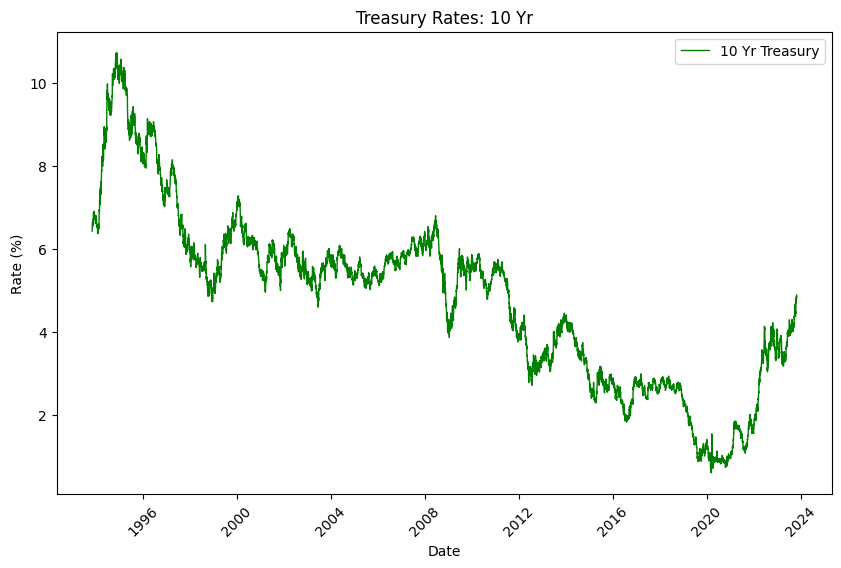

In [170]:
bond_yrs = [ '10 Yr']
for term in bond_yrs:
    full_plot(sliced_sovereign_data, term)

In [171]:
# check for null values
sliced_sovereign_data.isna().sum()

10 Yr    0
dtype: int64

In [172]:
## As we Saw above there are a lot of values missing for 30 Yr Treasury Bond so we will fetch the data for them through yfinance
import yfinance as yf
data = yf.download("^TYX", period="max")
data['30 Yr YF'] = data['Adj Close']
data

[*********************100%%**********************]  1 of 1 completed
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

             Open   High    Low  Close  Adj Close  Volume  30 Yr YF
Date                                                               
1977-02-15  7.700  7.700  7.700  7.700      7.700       0     7.700
1977-02-16  7.670  7.670  7.670  7.670      7.670       0     7.670
1977-02-17  7.670  7.670  7.670  7.670      7.670       0     7.670
1977-02-18  7.760  7.760  7.760  7.760      7.760       0     7.760
1977-02-22  7.770  7.770  7.770  7.770      7.770       0     7.770
...           ...    ...    ...    ...        ...     ...       ...
2024-12-16  4.582  4.627  4.576  4.608      4.608       0     4.608
2024-12-17  4.622  4.630  4.566  4.579      4.579       0     4.579
2024-12-18  4.610  4.660  4.583  4.659      4.659       0     4.659
2024-12-19  4.709  4.775  4.707  4.740      4.740       0     4.740
2024-12-20  4.736  4.740  4.681  4.716      4.716       0     4.716

[11989 rows x 7 columns]

In [173]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
yf_data_sliced = slice_dataframe(data, start_date='1993-10-30', end_date='2023-10-30', cols= ['30 Yr YF'])

Sliced DataFrame: 7533 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: 30 Yr YF


In [174]:
yf_data_sliced

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            30 Yr YF
Date                
1993-11-01     6.020
1993-11-02     6.058
1993-11-03     6.094
1993-11-04     6.180
1993-11-05     6.217
...              ...
2023-10-24     4.963
2023-10-25     5.092
2023-10-26     4.988
2023-10-27     5.023
2023-10-30     5.035

[7533 rows x 1 columns]

In [175]:
## now merging this with original sliced datafarme sliced_sovereign_data
merged_sovereign_data = sliced_sovereign_data.merge(yf_data_sliced, left_index=True, right_index=True)
merged_sovereign_data

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            10 Yr  30 Yr YF
Date                       
1993-11-01  6.420     6.020
1993-11-02  6.500     6.058
1993-11-03  6.550     6.094
1993-11-04  6.590     6.180
1993-11-05  6.600     6.217
...           ...       ...
2023-10-24  4.693     4.963
2023-10-25  4.736     5.092
2023-10-26  4.856     4.988
2023-10-27  4.814     5.023
2023-10-30  4.881     5.035

[7424 rows x 2 columns]

In [176]:
merged_sovereign_data.isna().sum()

10 Yr       0
30 Yr YF    0
dtype: int64

In [177]:
## As we saw above there are no nulls in data from yahoo finance so we'll use that for the 30 Yr treasurey bond.
sovereign_data_final = merged_sovereign_data

In [178]:
# check for nulls
sovereign_data_final.isna().sum()

10 Yr       0
30 Yr YF    0
dtype: int64

In [179]:
sovereign_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7424 entries, 1993-11-01 to 2023-10-30
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   10 Yr     7424 non-null   float64
 1   30 Yr YF  7424 non-null   float64
dtypes: float64(2)
memory usage: 174.0 KB


### 1.2) Adding Macro Variables

In [180]:
current_dir = os.getcwd()
macro_folder_path = os.path.join(current_dir, "Macro_Data")
print(macro_folder_path)

d:\_IncrementalMaybe\Strategy_Project\fin554_algo_trading_strategy_fall_2024_group_05\Macro_Data


### 1.2.1) Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average

In [181]:
cpi_file = os.path.join(macro_folder_path, "CPILFESL.csv")

In [182]:
df_cpi = pd.read_csv(cpi_file, index_col="DATE")
# primary null check
df_cpi.isna().sum()

CPILFESL    0
dtype: int64

In [183]:
df_cpi['inflation'] = df_cpi['CPILFESL'].pct_change()*100
df_cpi

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            CPILFESL  inflation
DATE                           
1993-01-01   150.100        NaN
1993-02-01   150.600   0.333111
1993-03-01   150.800   0.132802
1993-04-01   151.400   0.397878
1993-05-01   151.800   0.264201
...              ...        ...
2023-08-01   309.656   0.230138
2023-09-01   310.644   0.319064
2023-10-01   311.390   0.240146
2023-11-01   312.349   0.307974
2023-12-01   313.209   0.275333

[372 rows x 2 columns]

In [184]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
inf_data_sliced = slice_dataframe(df_cpi, start_date='1993-10-30', end_date='2023-10-30', cols= ['inflation'])
inf_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: inflation
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation
DATE                 
1993-11-01   0.325945
1993-12-01   0.259909
1994-01-01   0.129618
1994-02-01   0.194175
1994-03-01   0.322997
...               ...
2023-06-01   0.194704
2023-07-01   0.227092
2023-08-01   0.230138
2023-09-01   0.319064
2023-10-01   0.240146

[360 rows x 1 columns]

In [185]:
# forward filling the inflation to preserve the daily time granualarity as 
# Suppose January CPI is released on February 10th and if we backfill January’s inflation into January’s daily data we are inserting information that 
# was not available at that time So ffill makes more sense.
new_index_inf = pd.date_range(start=inf_data_sliced.index.min(), end='2023-10-30', freq='D')
inf_data_final = inf_data_sliced.reindex(new_index_inf, method='ffill')
inf_data_final

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation
1993-11-01   0.325945
1993-11-02   0.325945
1993-11-03   0.325945
1993-11-04   0.325945
1993-11-05   0.325945
...               ...
2023-10-26   0.240146
2023-10-27   0.240146
2023-10-28   0.240146
2023-10-29   0.240146
2023-10-30   0.240146

[10956 rows x 1 columns]

In [186]:
# check for nulls
inf_data_final.isna().sum()

inflation    0
dtype: int64

In [187]:
inf_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inflation  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.2) Producer Price Index by Commodity: All Commodities

In [188]:
ppi_file = os.path.join(macro_folder_path, "PPIACO.csv")

In [189]:
df_ppi = pd.read_csv(ppi_file, index_col="DATE")
#primary null check
df_ppi.isna().sum()

PPIACO    0
dtype: int64

In [190]:
df_ppi['ppi_mom'] = df_ppi['PPIACO'].pct_change()*100
df_ppi

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

             PPIACO   ppi_mom
DATE                         
1993-01-01  118.000       NaN
1993-02-01  118.400  0.338983
1993-03-01  118.700  0.253378
1993-04-01  119.300  0.505476
1993-05-01  119.700  0.335289
...             ...       ...
2023-08-01  257.680  1.514764
2023-09-01  258.934  0.486650
2023-10-01  255.192 -1.445156
2023-11-01  252.856 -0.915389
2023-12-01  249.866 -1.182491

[372 rows x 2 columns]

In [191]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
ppi_data_sliced = slice_dataframe(df_ppi, start_date='1993-10-30', end_date='2023-10-30', cols= ['ppi_mom'])
ppi_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: ppi_mom
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

             ppi_mom
DATE                
1993-11-01 -0.083963
1993-12-01 -0.336134
1994-01-01  0.421585
1994-02-01  0.167926
1994-03-01  0.335289
...              ...
2023-06-01  0.074900
2023-07-01 -0.009848
2023-08-01  1.514764
2023-09-01  0.486650
2023-10-01 -1.445156

[360 rows x 1 columns]

In [192]:
# forward filling the ppi_mom to preserve the daily time granualarity just like inflation
new_index_ppi = pd.date_range(start=ppi_data_sliced.index.min(), end='2023-10-30', freq='D')
ppi_data_final = ppi_data_sliced.reindex(new_index_ppi, method='ffill')
ppi_data_final

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

             ppi_mom
1993-11-01 -0.083963
1993-11-02 -0.083963
1993-11-03 -0.083963
1993-11-04 -0.083963
1993-11-05 -0.083963
...              ...
2023-10-26 -1.445156
2023-10-27 -1.445156
2023-10-28 -1.445156
2023-10-29 -1.445156
2023-10-30 -1.445156

[10956 rows x 1 columns]

In [193]:
# check for nulls
ppi_data_final.isna().sum()

ppi_mom    0
dtype: int64

In [194]:
ppi_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ppi_mom  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.3) Federal Funds Effective Rate

In [195]:
fed_funds_file = os.path.join(macro_folder_path, "FEDFUNDS.csv")

In [196]:
df_fed = pd.read_csv(fed_funds_file, index_col="DATE")
# primary null check
print(df_fed.isna().sum(), '\n')
df_fed.info()

FEDFUNDS    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 412 entries, 8/1/1990 to 11/1/2024
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  412 non-null    float64
dtypes: float64(1)
memory usage: 6.4+ KB


In [197]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
funds_data_sliced = slice_dataframe(df_fed, start_date='1993-10-30', end_date='2023-10-30', cols= ['FEDFUNDS'])
funds_data_sliced.rename(columns={"FEDFUNDS": "fed_funds_rate"}, inplace=True)
funds_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: FEDFUNDS
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            fed_funds_rate
DATE                      
1993-11-01            4.75
1993-12-01            4.75
1994-01-01            4.75
1994-02-01            4.75
1994-03-01            4.75
...                    ...
2023-06-01            4.05
2023-07-01            4.10
2023-08-01            4.10
2023-09-01            4.10
2023-10-01            4.10

[360 rows x 1 columns]

In [198]:
# forward filling the fed funds rate to preserve the daily time granualarity as Central banks often set a target rate that remains stable until the next decision or announcement.
new_index_fed = pd.date_range(start=funds_data_sliced.index.min(), end='2023-10-30', freq='D')
funds_data_final = funds_data_sliced.reindex(new_index_fed, method='ffill')
funds_data_final

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            fed_funds_rate
1993-11-01            4.75
1993-11-02            4.75
1993-11-03            4.75
1993-11-04            4.75
1993-11-05            4.75
...                    ...
2023-10-26            4.10
2023-10-27            4.10
2023-10-28            4.10
2023-10-29            4.10
2023-10-30            4.10

[10956 rows x 1 columns]

In [199]:
# check for nulls
funds_data_final.isna().sum()

fed_funds_rate    0
dtype: int64

In [200]:
funds_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fed_funds_rate  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.4) Unemployment Rate

In [201]:
unemp_file = os.path.join(macro_folder_path, "UNRATE.csv")

In [202]:
df_unemp = pd.read_csv(unemp_file, index_col="DATE")
# primary null check
print(df_unemp.isna().sum(), '\n')
df_unemp.info()

UNRATE    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 1993-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UNRATE  372 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB


In [203]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
unemp_data_sliced = slice_dataframe(df_unemp, start_date='1993-10-30', end_date='2023-10-30', cols= ['UNRATE'])
unemp_data_sliced.rename(columns={"UNRATE": "unemployment_rate"}, inplace=True)
unemp_data_sliced

Sliced DataFrame: 360 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-01 00:00:00
Selected columns: UNRATE
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            unemployment_rate
DATE                         
1993-11-01                6.6
1993-12-01                6.5
1994-01-01                6.6
1994-02-01                6.6
1994-03-01                6.5
...                       ...
2023-06-01                3.6
2023-07-01                3.5
2023-08-01                3.8
2023-09-01                3.8
2023-10-01                3.8

[360 rows x 1 columns]

In [204]:
# forward filling the unemployment rate to preserve the daily time granualarity as a target rate is set that remains stable until the next decision or announcement.
new_index_unemp = pd.date_range(start=unemp_data_sliced.index.min(), end='2023-10-30', freq='D')
unemp_data_final = unemp_data_sliced.reindex(new_index_unemp, method='ffill')
unemp_data_final

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            unemployment_rate
1993-11-01                6.6
1993-11-02                6.6
1993-11-03                6.6
1993-11-04                6.6
1993-11-05                6.6
...                       ...
2023-10-26                3.8
2023-10-27                3.8
2023-10-28                3.8
2023-10-29                3.8
2023-10-30                3.8

[10956 rows x 1 columns]

In [205]:
# check for nulls
unemp_data_final.isna().sum()

unemployment_rate    0
dtype: int64

In [206]:
unemp_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unemployment_rate  10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


### 1.2.5) 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity

In [207]:
t10y2_file = os.path.join(macro_folder_path, "T10Y2Y.csv")

In [208]:
df_10y2 = pd.read_csv(t10y2_file, index_col="DATE")
# primary null check
print(df_10y2.isna().sum(), '\n')
df_10y2.info()

T10Y2Y    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 8065 entries, 1993-01-04 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  8065 non-null   object
dtypes: object(1)
memory usage: 126.0+ KB


In [209]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023 and processing to get standard datatype format
t10y2_data_sliced = slice_dataframe(df_10y2, start_date='1993-10-30', end_date='2023-10-30', cols= ['T10Y2Y'])
t10y2_data_sliced.rename(columns={"T10Y2Y": "10_minus_2"}, inplace=True)
t10y2_data_sliced.reset_index(inplace=True)
t10y2_data_sliced['10_minus_2'] = t10y2_data_sliced['10_minus_2'].replace('.', np.nan)
t10y2_data_sliced['10_minus_2'] = t10y2_data_sliced['10_minus_2'].astype('float')
t10y2_data_sliced.set_index('DATE', inplace=True)
t10y2_data_sliced

Traceback (most recent call last):


Sliced DataFrame: 7826 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: T10Y2Y
Unexpected exception formatting exception. Falling back to standard exception


  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python3

            10_minus_2
DATE                  
1993-11-01        1.45
1993-11-02        1.47
1993-11-03        1.54
1993-11-04        1.54
1993-11-05        1.55
...                ...
2023-10-24       -0.19
2023-10-25       -0.13
2023-10-26       -0.16
2023-10-27       -0.15
2023-10-30       -0.15

[7826 rows x 1 columns]

#### We will impute the missing values later on using other macro data

In [210]:
t10y2_data_sliced.isna().sum()

10_minus_2    321
dtype: int64

### 1.2.6) Real GDP

In [211]:
gdp_file = os.path.join(macro_folder_path, "GDPC1.csv")

In [212]:
df_gdp = pd.read_csv(gdp_file, index_col="DATE")
# primary null check
print(df_gdp.isna().sum(), '\n')
df_gdp.info()

GDPC1_PCH    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 1993-01-01 to 2023-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GDPC1_PCH  124 non-null    float64
dtypes: float64(1)
memory usage: 1.9+ KB


In [213]:
# forward filling the unemployment rate to preserve the daily time granualarity as a target rate is set that remains stable until the next decision or announcement.
df_gdp.index = pd.to_datetime(df_gdp.index)
new_index_gdp = pd.date_range(start=df_gdp.index.min(), end='2023-10-30', freq='D')
gdp_data = df_gdp.reindex(new_index_gdp, method='ffill')
gdp_data

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            GDPC1_PCH
1993-01-01    0.16694
1993-01-02    0.16694
1993-01-03    0.16694
1993-01-04    0.16694
1993-01-05    0.16694
...               ...
2023-10-26    0.78867
2023-10-27    0.78867
2023-10-28    0.78867
2023-10-29    0.78867
2023-10-30    0.78867

[11260 rows x 1 columns]

In [214]:
# now slicing the dataframe between required dates of October 30, 1993 and October 30, 2023
gdp_data_sliced = slice_dataframe(gdp_data, start_date='1993-11-01', end_date='2023-10-30', cols= ['GDPC1_PCH'])
gdp_data_sliced.rename(columns={"GDPC1_PCH": "gdp"}, inplace=True)
gdp_data_sliced

Sliced DataFrame: 10956 rows, 1 columns
Date range: from 1993-11-01 00:00:00 to 2023-10-30 00:00:00
Selected columns: GDPC1_PCH
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

                gdp
1993-11-01  1.36015
1993-11-02  1.36015
1993-11-03  1.36015
1993-11-04  1.36015
1993-11-05  1.36015
...             ...
2023-10-26  0.78867
2023-10-27  0.78867
2023-10-28  0.78867
2023-10-29  0.78867
2023-10-30  0.78867

[10956 rows x 1 columns]

In [215]:
gdp_data_final = gdp_data_sliced.copy()
gdp_data_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gdp     10956 non-null  float64
dtypes: float64(1)
memory usage: 171.2 KB


# To make teh model better we could've added more macro variables. But these seem like the best in predicting bond market movement so just using these.

# 2) Preprocessing-Data and Feature Engineering

In [216]:
macro_frames = [ppi_data_final, funds_data_final, unemp_data_final, t10y2_data_sliced, gdp_data_final]

In [217]:
df_macro = inf_data_final.join(macro_frames, how='left')
df_macro

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation   ppi_mom  fed_funds_rate  unemployment_rate  \
1993-11-01   0.325945 -0.083963            4.75                6.6   
1993-11-02   0.325945 -0.083963            4.75                6.6   
1993-11-03   0.325945 -0.083963            4.75                6.6   
1993-11-04   0.325945 -0.083963            4.75                6.6   
1993-11-05   0.325945 -0.083963            4.75                6.6   
...               ...       ...             ...                ...   
2023-10-26   0.240146 -1.445156            4.10                3.8   
2023-10-27   0.240146 -1.445156            4.10                3.8   
2023-10-28   0.240146 -1.445156            4.10                3.8   
2023-10-29   0.240146 -1.445156            4.10                3.8   
2023-10-30   0.240146 -1.445156            4.10                3.8   

            10_minus_2      gdp  
1993-11-01        1.45  1.36015  
1993-11-02        1.47  1.36015  
1993-11-03        1.54  1.36015  
1993-11-04        1.54 

In [218]:
print(df_macro.isna().sum(), '\n')

df_macro.info()

inflation               0
ppi_mom                 0
fed_funds_rate          0
unemployment_rate       0
10_minus_2           3451
gdp                     0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflation          10956 non-null  float64
 1   ppi_mom            10956 non-null  float64
 2   fed_funds_rate     10956 non-null  float64
 3   unemployment_rate  10956 non-null  float64
 4   10_minus_2         7505 non-null   float64
 5   gdp                10956 non-null  float64
dtypes: float64(6)
memory usage: 599.2 KB


In [219]:
# running a expanding window KNN imputer to impute the values of 10_minus_2
n_neighbors = 5
min_periods = 5
cols = ['inflation', 'ppi_mom', 'fed_funds_rate', 'unemployment_rate', 'gdp', '10_minus_2']
target_col = '10_minus_2'

df_result = df_macro.copy()

# scaler to standardise values
scaler = StandardScaler()

# missing val indices
missing_indices = df_macro[df_macro[target_col].isna()].index

# sorted dataframe to impute the values later on
df_sorted = df_macro.sort_index()

# getting non null data before the first null index
first_missing_idx = missing_indices[0]
initial_data = df_sorted.loc[:first_missing_idx].copy()
h_data = initial_data[~initial_data[target_col].isna()]

# minimum periods required to run teh imputation
if len(h_data) < min_periods:
    print(f"Not enough initial data points (need {min_periods}, have {len(h_data)})")
else:
    for idx in missing_indices:
        curr_data = df_result.loc[:idx, cols].copy()
        
        scaler.fit(curr_data)
        
        curr_data_scaled = pd.DataFrame(scaler.transform(curr_data), columns=cols, index=curr_data.index)
        
        current_n_neighbors = min(n_neighbors, len(curr_data) - 1)
        imputer = KNNImputer(n_neighbors=current_n_neighbors)
        curr_data_imputed_scaled = imputer.fit_transform(curr_data_scaled)
        
        curr_data_imputed = scaler.inverse_transform(curr_data_imputed_scaled)
        
        df_result.loc[idx, target_col] = curr_data_imputed[-1][cols.index(target_col)]

print(f"Number of missing values before imputation: {df_macro[target_col].isna().sum()}")
print(f"Number of missing values after imputation: {df_result[target_col].isna().sum()}")

Number of missing values before imputation: 3451
Number of missing values after imputation: 0


In [220]:
df_macro_imputed = df_result.copy()
df_macro_imputed.head(11)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation   ppi_mom  fed_funds_rate  unemployment_rate  \
1993-11-01   0.325945 -0.083963            4.75                6.6   
1993-11-02   0.325945 -0.083963            4.75                6.6   
1993-11-03   0.325945 -0.083963            4.75                6.6   
1993-11-04   0.325945 -0.083963            4.75                6.6   
1993-11-05   0.325945 -0.083963            4.75                6.6   
1993-11-06   0.325945 -0.083963            4.75                6.6   
1993-11-07   0.325945 -0.083963            4.75                6.6   
1993-11-08   0.325945 -0.083963            4.75                6.6   
1993-11-09   0.325945 -0.083963            4.75                6.6   
1993-11-10   0.325945 -0.083963            4.75                6.6   
1993-11-11   0.325945 -0.083963            4.75                6.6   

            10_minus_2      gdp  
1993-11-01        1.45  1.36015  
1993-11-02        1.47  1.36015  
1993-11-03        1.54  1.36015  
1993-11-04        1.54 

In [221]:
print(df_macro_imputed.isna().sum())

inflation            0
ppi_mom              0
fed_funds_rate       0
unemployment_rate    0
10_minus_2           0
gdp                  0
dtype: int64


In [222]:
df_macro_imputed.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation   ppi_mom  fed_funds_rate  unemployment_rate  \
1993-11-01   0.325945 -0.083963            4.75                6.6   
1993-11-02   0.325945 -0.083963            4.75                6.6   
1993-11-03   0.325945 -0.083963            4.75                6.6   
1993-11-04   0.325945 -0.083963            4.75                6.6   
1993-11-05   0.325945 -0.083963            4.75                6.6   

            10_minus_2      gdp  
1993-11-01        1.45  1.36015  
1993-11-02        1.47  1.36015  
1993-11-03        1.54  1.36015  
1993-11-04        1.54  1.36015  
1993-11-05        1.55  1.36015  

 # Analysis for 10 - year bond

### Design Experiment using multiple models for parameter optimization

In [223]:
# getting just teh 10-year bond
sovereign_data_10 = sovereign_data_final[['10 Yr']]
df = sovereign_data_10.copy()
df = df.sort_index()
df.rename(columns={'10 Yr': 'yield_10y'}, inplace=True)
df.tail()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            yield_10y
Date                 
2023-10-24      4.693
2023-10-25      4.736
2023-10-26      4.856
2023-10-27      4.814
2023-10-30      4.881

In [224]:
df_macro.head(3)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            inflation   ppi_mom  fed_funds_rate  unemployment_rate  \
1993-11-01   0.325945 -0.083963            4.75                6.6   
1993-11-02   0.325945 -0.083963            4.75                6.6   
1993-11-03   0.325945 -0.083963            4.75                6.6   

            10_minus_2      gdp  
1993-11-01        1.45  1.36015  
1993-11-02        1.47  1.36015  
1993-11-03        1.54  1.36015  

In [225]:
# defining teh parameter space for fedorov's parameter optimization
parameter_space = {
    'RSI_period': [10, 14, 20, 30, 50],
    'SMA_short': [7, 14, 23, 28, 35],
    'SMA_long': [63, 112, 252, 300, 365],
    'EMA_span_short': [7, 14, 23, 28, 35],
    'EMA_span_long': [63, 112, 252, 300, 365],
    'MACD_fast': [10, 12, 20, 26, 30],
    'MACD_slow': [26, 50, 100, 150, 200],
    'BB_std_dev': [1.5, 2.0, 2.5, 3.0, 3.5],
    'Ichimoku_Tenkan': [11, 16, 21, 28, 32],
    'Ichimoku_Kijun': [35, 42, 63, 78, 92],
    'Ichimoku_SenkouB': [112, 192, 252, 300, 365]
}

In [226]:
# fedorov optimizer class for design experiment and parameter optimization (took a lot of help from ChatGPT as the readily available pyDOE2 has a deprecated library)
class EnhancedFedorovOptimizer:
    def __init__(self, parameter_space, data, n_designs=50):
        self.parameter_space = parameter_space
        self.data = data
        self.n_designs = n_designs
        self.scaler = StandardScaler()
        
        # defining teh models with default hyperparameters used for combination evaluation
        self.models = {
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'xgboost': xgb.XGBClassifier(n_estimators=100, random_state=42),
            'lasso': Lasso(random_state=42),
            'lgbm': LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
        }
    
    # generating teh design matrix for optimality checks
    def generate_design_matrix(self):
        n_params = len(self.parameter_space)
        design_matrix = []
        
        for _ in range(self.n_designs):
            combination = {}
            for param, values in self.parameter_space.items():
                idx = np.random.randint(0, len(values))
                combination[param] = values[idx]
            design_matrix.append(combination)
        
        X = np.array([[list(d.values())] for d in design_matrix])
        X = X.reshape(self.n_designs, n_params)
        X_augmented = np.column_stack([np.ones(self.n_designs), X])
        info_matrix = X_augmented.T @ X_augmented
        
        optimality_metrics = {
            'D-optimality': np.linalg.det(info_matrix),
            'A-optimality': -np.trace(np.linalg.inv(info_matrix)),
            'E-optimality': np.min(np.linalg.eigvals(info_matrix)),
            'condition_number': np.linalg.cond(info_matrix)
        }
        
        return design_matrix, optimality_metrics

    # momentum based indicatiors parameter combinations    
    def generate_features(self, combination):
        df = self.data.copy()
        
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        
        delta = df['yield_10y'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=int(combination['RSI_period'])).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=int(combination['RSI_period'])).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        df['SMA_short'] = df['yield_10y'].rolling(int(combination['SMA_short'])).mean()
        df['SMA_long'] = df['yield_10y'].rolling(int(combination['SMA_long'])).mean()
        df['EMA_short'] = df['yield_10y'].ewm(span=int(combination['EMA_span_short'])).mean()
        df['EMA_long'] = df['yield_10y'].ewm(span=int(combination['EMA_span_long'])).mean()
        
        df['MACD'] = (df['yield_10y'].ewm(span=int(combination['MACD_fast'])).mean() - df['yield_10y'].ewm(span=int(combination['MACD_slow'])).mean())
        
        bb_middle = df['yield_10y'].rolling(20).mean()
        bb_std = df['yield_10y'].rolling(20).std()
        df['BB_upper'] = bb_middle + combination['BB_std_dev'] * bb_std
        df['BB_lower'] = bb_middle - combination['BB_std_dev'] * bb_std
        df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / bb_middle
        
        for period, name in [(combination['Ichimoku_Tenkan'], 'Tenkan'),
                           (combination['Ichimoku_Kijun'], 'Kijun'),
                           (combination['Ichimoku_SenkouB'], 'SenkouB')]:
            period = int(period)
            high = df['yield_10y'].rolling(period).max()
            low = df['yield_10y'].rolling(period).min()
            df[f'Ichimoku_{name}'] = (high + low) / 2
        
        df['Volatility'] = df['yield_10y'].rolling(20).std()
        df['MOM'] = df['yield_10y'].pct_change(20)
        df['Yield_Change'] = df['yield_10y'].diff()
        df['Yield_Change_5d'] = df['yield_10y'].diff(5)
        df['Yield_Change_20d'] = df['yield_10y'].diff(20)
        
        return df.dropna()
    
    def prepare_features(self, df):
        feature_columns = ['RSI', 'SMA_short', 'SMA_long', 'EMA_short', 'EMA_long', 
                         'MACD', 'BB_width', 'Ichimoku_Tenkan', 'Ichimoku_Kijun', 
                         'Ichimoku_SenkouB', 'Volatility', 'MOM', 'Yield_Change',
                         'Yield_Change_5d', 'Yield_Change_20d']
        
        macro_columns = ['inflation', 'ppi_mom', 'fed_funds_rate', 'unemployment_rate', 
                        '10_minus_2', 'gdp']
        for col in macro_columns:
            if col in df.columns:
                feature_columns.append(col)
        
        df['yield_10y_n'] = df['yield_10y'].shift()
        df = df.dropna()
        
        X = df[feature_columns]
        y = df['yield_10y']
        
        return X, y
    
    def evaluate_combination(self, combination):
        try:
            df_features = self.generate_features(combination)
            # minimum 50 samples required to evaluate the parameter combinations
            if len(df_features) < 50:
                return None
            
            X, y = self.prepare_features(df_features)
            
            # using 10% as initial train size and up to 60% of data
            initial_train_size = int(len(X) * 0.1) 
            final_train_size = int(len(X) * 0.6)
            step_size = 252
            
            all_predictions = {model_name: [] for model_name in self.models.keys()}
            all_actuals = {model_name: [] for model_name in self.models.keys()}
            
            model_metrics = {}
            
            # using expanding window till max train size
            for end_idx in range(initial_train_size, final_train_size, step_size):
                X_train = X[:end_idx]
                y_train = y[:end_idx]
                X_test = X[end_idx:end_idx + step_size]
                y_test = y[end_idx:end_idx + step_size]
                
                if end_idx + step_size > final_train_size:
                    X_test = X[end_idx:final_train_size]
                    y_test = y[end_idx:final_train_size]
                
                # scaling the features
                X_train_scaled = self.scaler.fit_transform(X_train)
                X_test_scaled = self.scaler.transform(X_test)
                
                for model_name, model in self.models.items():
                    print(f"{model_name} - Training window end: {end_idx}")
                    if model_name in ['random_forest', 'xgboost']:
                        y_train_diff = y_train.diff().dropna()
                        y_test_diff = y_test.diff().dropna()
                        y_train_class = np.sign(y_train_diff)
                        y_test_class = np.sign(y_test_diff)
                        
                        X_train_adj = X_train_scaled[1:]
                        X_test_adj = X_test_scaled[1:]
                        
                        if model_name == 'xgboost':
                            # convert -1, 0, 1 to 0, 1, 2 for XGBoost
                            y_train_class = (y_train_class + 1).astype(int)
                            y_test_class = (y_test_class + 1).astype(int)
                        
                        model.fit(X_train_adj, y_train_class)
                        y_pred_class = model.predict(X_test_adj)
                        
                        if model_name == 'xgboost':
                            y_pred_class = y_pred_class - 1
                            y_test_class = y_test_class - 1
                        
                        all_predictions[model_name].extend(y_pred_class)
                        all_actuals[model_name].extend(y_test_class)
                        
                    else:
                        # lasso and lgbm models
                        model.fit(X_train_scaled, y_train)
                        y_pred = model.predict(X_test_scaled)
                        
                        all_predictions[model_name].extend(y_pred)
                        all_actuals[model_name].extend(y_test)
            
            # prediction metrics
            for model_name in self.models.keys():
                if model_name in ['random_forest', 'xgboost']:
                    precision = precision_score(all_actuals[model_name], all_predictions[model_name], 
                                            average='weighted', zero_division=0)
                    recall = recall_score(all_actuals[model_name], all_predictions[model_name], 
                                        average='weighted', zero_division=0)
                    f1 = f1_score(all_actuals[model_name], all_predictions[model_name], 
                                average='weighted', zero_division=0)
                    conf_matrix = confusion_matrix(all_actuals[model_name], all_predictions[model_name])
                    
                    labels = ['Down', 'No Change', 'Up']
                    conf_matrix_df = pd.DataFrame(
                        conf_matrix,
                        index=[f'Actual {label}' for label in labels],
                        columns=[f'Predicted {label}' for label in labels]
                    )
                    
                    model_metrics[model_name] = {
                        'accuracy': accuracy_score(all_actuals[model_name], all_predictions[model_name]),
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1,
                        'confusion_matrix': conf_matrix_df
                    }
                    
                else:
                    # regression metrics
                    model_metrics[model_name] = {
                        'r2': r2_score(all_actuals[model_name], all_predictions[model_name]),
                        'mse': mean_squared_error(all_actuals[model_name], all_predictions[model_name]),
                        'mae': mean_absolute_error(all_actuals[model_name], all_predictions[model_name])
                    }
            
            return model_metrics
            
        except Exception as e:
            print(f"Error in evaluate_combination: {str(e)}")
            return None
    
    def optimize(self):
        # Generate design matrix with optimality criteria
        design_matrix, optimality_metrics = self.generate_design_matrix()
        
        # Track best results for each model
        best_results = {
            model_name: {
                'metrics': {'r2': -np.inf} if model_name not in ['random_forest', 'xgboost'] 
                          else {'accuracy': -np.inf},
                'params': None
            }
            for model_name in self.models.keys()
        }
        
        parameter_importance = {
            model_name: {param: 0 for param in self.parameter_space.keys()}
            for model_name in self.models.keys()
        }
        
        # Evaluate each combination
        for combination in design_matrix:
            metrics = self.evaluate_combination(combination)
            if metrics is not None:
                for model_name, model_metrics in metrics.items():
                    # Update best results if better performance found
                    if model_name in ['random_forest', 'xgboost']:
                        if model_metrics['accuracy'] > best_results[model_name]['metrics']['accuracy']:
                            best_results[model_name]['metrics'] = model_metrics
                            best_results[model_name]['params'] = combination
                            for param in combination:
                                parameter_importance[model_name][param] += 1
                    else:
                        if model_metrics['r2'] > best_results[model_name]['metrics']['r2']:
                            best_results[model_name]['metrics'] = model_metrics
                            best_results[model_name]['params'] = combination
                            for param in combination:
                                parameter_importance[model_name][param] += 1
        
        # Normalize parameter importance
        for model_name in self.models.keys():
            total_updates = sum(parameter_importance[model_name].values())
            if total_updates > 0:
                parameter_importance[model_name] = {
                    param: count/total_updates 
                    for param, count in parameter_importance[model_name].items()
                }
        
        # Calculate consensus parameter importance
        consensus_importance = {}
        for param in self.parameter_space.keys():
            importance_values = [importance[param] for importance in parameter_importance.values()]
            consensus_importance[param] = np.mean(importance_values)
        
        return best_results, parameter_importance, consensus_importance, optimality_metrics

In [227]:
# initialize optimizer
optimizer = EnhancedFedorovOptimizer(parameter_space, df, n_designs=50)

# optimizer results
best_results, model_importance, consensus, optimality = optimizer.optimize()

random_forest - Training window end: 717
xgboost - Training window end: 717
lasso - Training window end: 717
lgbm - Training window end: 717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2877
[LightGBM] [Info] Number of data points in the train set: 717, number of used features: 15
[LightGBM] [Info] Start training from score 8.367322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [228]:
# optimality results
print("\nDesign Optimality Metrics:")
for metric, value in optimality.items():
    print(f"{metric}: {value}")

# best results
for model_name, results in best_results.items():
    print(f"\nResults for {model_name}:")
    print(f"Best Parameters: {results['params']}")
    print(f"Best Metrics: {results['metrics']}")


Design Optimality Metrics:
D-optimality: 3.946266282428697e+47
A-optimality: -1.966762034873502
E-optimality: 0.5218402081138575
condition_number: 17503018.93446931

Results for random_forest:
Best Parameters: {'RSI_period': 50, 'SMA_short': 35, 'SMA_long': 63, 'EMA_span_short': 35, 'EMA_span_long': 63, 'MACD_fast': 20, 'MACD_slow': 100, 'BB_std_dev': 1.5, 'Ichimoku_Tenkan': 11, 'Ichimoku_Kijun': 63, 'Ichimoku_SenkouB': 112}
Best Metrics: {'accuracy': 0.9983521010711343, 'precision': 0.9984138972809667, 'recall': 0.9983521010711343, 'f1_score': 0.998367062599105, 'confusion_matrix':                   Predicted Down  Predicted No Change  Predicted Up
Actual Down                 1761                    4             0
Actual No Change               0                  154             0
Actual Up                      0                    2          1720}

Results for xgboost:
Best Parameters: {'RSI_period': 50, 'SMA_short': 14, 'SMA_long': 300, 'EMA_span_short': 28, 'EMA_span_long': 63, '

In [229]:
best_params_vals = [value for key, value in best_results.items() if key == 'lasso']
best_params = best_params_vals[0]['params']
print("Best Parameters:", best_params)

Best Parameters: {'RSI_period': 14, 'SMA_short': 28, 'SMA_long': 365, 'EMA_span_short': 7, 'EMA_span_long': 300, 'MACD_fast': 12, 'MACD_slow': 50, 'BB_std_dev': 2.5, 'Ichimoku_Tenkan': 11, 'Ichimoku_Kijun': 35, 'Ichimoku_SenkouB': 252}


## Getting data with optimized params and plotting various technical indicators

In [230]:
# generating the indicators using the best params from result above
df_indicators = df.copy()

if not isinstance(df_indicators.index, pd.DatetimeIndex):
    df_indicators.index = pd.to_datetime(df_indicators.index)

# calculating the rsi's
delta = df_indicators['yield_10y'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=int(best_params['RSI_period'])).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=int(best_params['RSI_period'])).mean()
rs = gain / loss
df_indicators['RSI'] = 100 - (100 / (1 + rs))

# calculating long and short moving averages
df_indicators['SMA_short'] = df_indicators['yield_10y'].rolling(int(best_params['SMA_short'])).mean()
df_indicators['SMA_long'] = df_indicators['yield_10y'].rolling(int(best_params['SMA_long'])).mean()
df_indicators['EMA_short'] = df_indicators['yield_10y'].ewm(span=int(best_params['EMA_span_short'])).mean()
df_indicators['EMA_long'] = df_indicators['yield_10y'].ewm(span=int(best_params['EMA_span_long'])).mean()

# calculating MACD using fast and slow MACD
df_indicators['MACD'] = (df_indicators['yield_10y'].ewm(span=int(best_params['MACD_fast'])).mean() - df_indicators['yield_10y'].ewm(span=int(best_params['MACD_slow'])).mean())

# calculating teh bollinger bands
bb_middle = df_indicators['yield_10y'].rolling(20).mean()
bb_std = df_indicators['yield_10y'].rolling(20).std()
df_indicators['BB_upper'] = bb_middle + best_params['BB_std_dev'] * bb_std
df_indicators['BB_lower'] = bb_middle - best_params['BB_std_dev'] * bb_std
df_indicators['BB_width'] = (df_indicators['BB_upper'] - df_indicators['BB_lower']) / bb_middle

# calculating ichimoku lines
for period, name in [(best_params['Ichimoku_Tenkan'], 'Tenkan'), (best_params['Ichimoku_Kijun'], 'Kijun'), (best_params['Ichimoku_SenkouB'], 'SenkouB')]:
    period = int(period)
    high = df_indicators['yield_10y'].rolling(period).max()
    low = df_indicators['yield_10y'].rolling(period).min()
    df_indicators[f'Ichimoku_{name}'] = (high + low) / 2

# calculating teh additional features
df_indicators['Volatility'] = df_indicators['yield_10y'].rolling(20).std()
df_indicators['MOM'] = df_indicators['yield_10y'].pct_change(20)
df_indicators['Yield_Change'] = df_indicators['yield_10y'].diff()
df_indicators['Yield_Change_5d'] = df_indicators['yield_10y'].diff(5)
df_indicators['Yield_Change_20d'] = df_indicators['yield_10y'].diff(20)

In [231]:
print(df_indicators.head())

            yield_10y  RSI  SMA_short  SMA_long  EMA_short  EMA_long  \
Date                                                                   
1993-11-01       6.42  NaN        NaN       NaN   6.420000  6.420000   
1993-11-02       6.50  NaN        NaN       NaN   6.465714  6.460133   
1993-11-03       6.55  NaN        NaN       NaN   6.502162  6.490289   
1993-11-04       6.59  NaN        NaN       NaN   6.534286  6.515466   
1993-11-05       6.60  NaN        NaN       NaN   6.555826  6.532599   

                MACD  BB_upper  BB_lower  BB_width  Ichimoku_Tenkan  \
Date                                                                  
1993-11-01  0.000000       NaN       NaN       NaN              NaN   
1993-11-02  0.002533       NaN       NaN       NaN              NaN   
1993-11-03  0.005429       NaN       NaN       NaN              NaN   
1993-11-04  0.008674       NaN       NaN       NaN              NaN   
1993-11-05  0.010871       NaN       NaN       NaN              NaN  

In [232]:
# Check for missing values
print("\nMissing values:")
print(df_indicators.isnull().sum())


Missing values:
yield_10y             0
RSI                  13
SMA_short            27
SMA_long            364
EMA_short             0
EMA_long              0
MACD                  0
BB_upper             19
BB_lower             19
BB_width             19
Ichimoku_Tenkan      10
Ichimoku_Kijun       34
Ichimoku_SenkouB    251
Volatility           19
MOM                  20
Yield_Change          1
Yield_Change_5d       5
Yield_Change_20d     20
dtype: int64


In [233]:
best_params

{'RSI_period': 14,
 'SMA_short': 28,
 'SMA_long': 365,
 'EMA_span_short': 7,
 'EMA_span_long': 300,
 'MACD_fast': 12,
 'MACD_slow': 50,
 'BB_std_dev': 2.5,
 'Ichimoku_Tenkan': 11,
 'Ichimoku_Kijun': 35,
 'Ichimoku_SenkouB': 252}

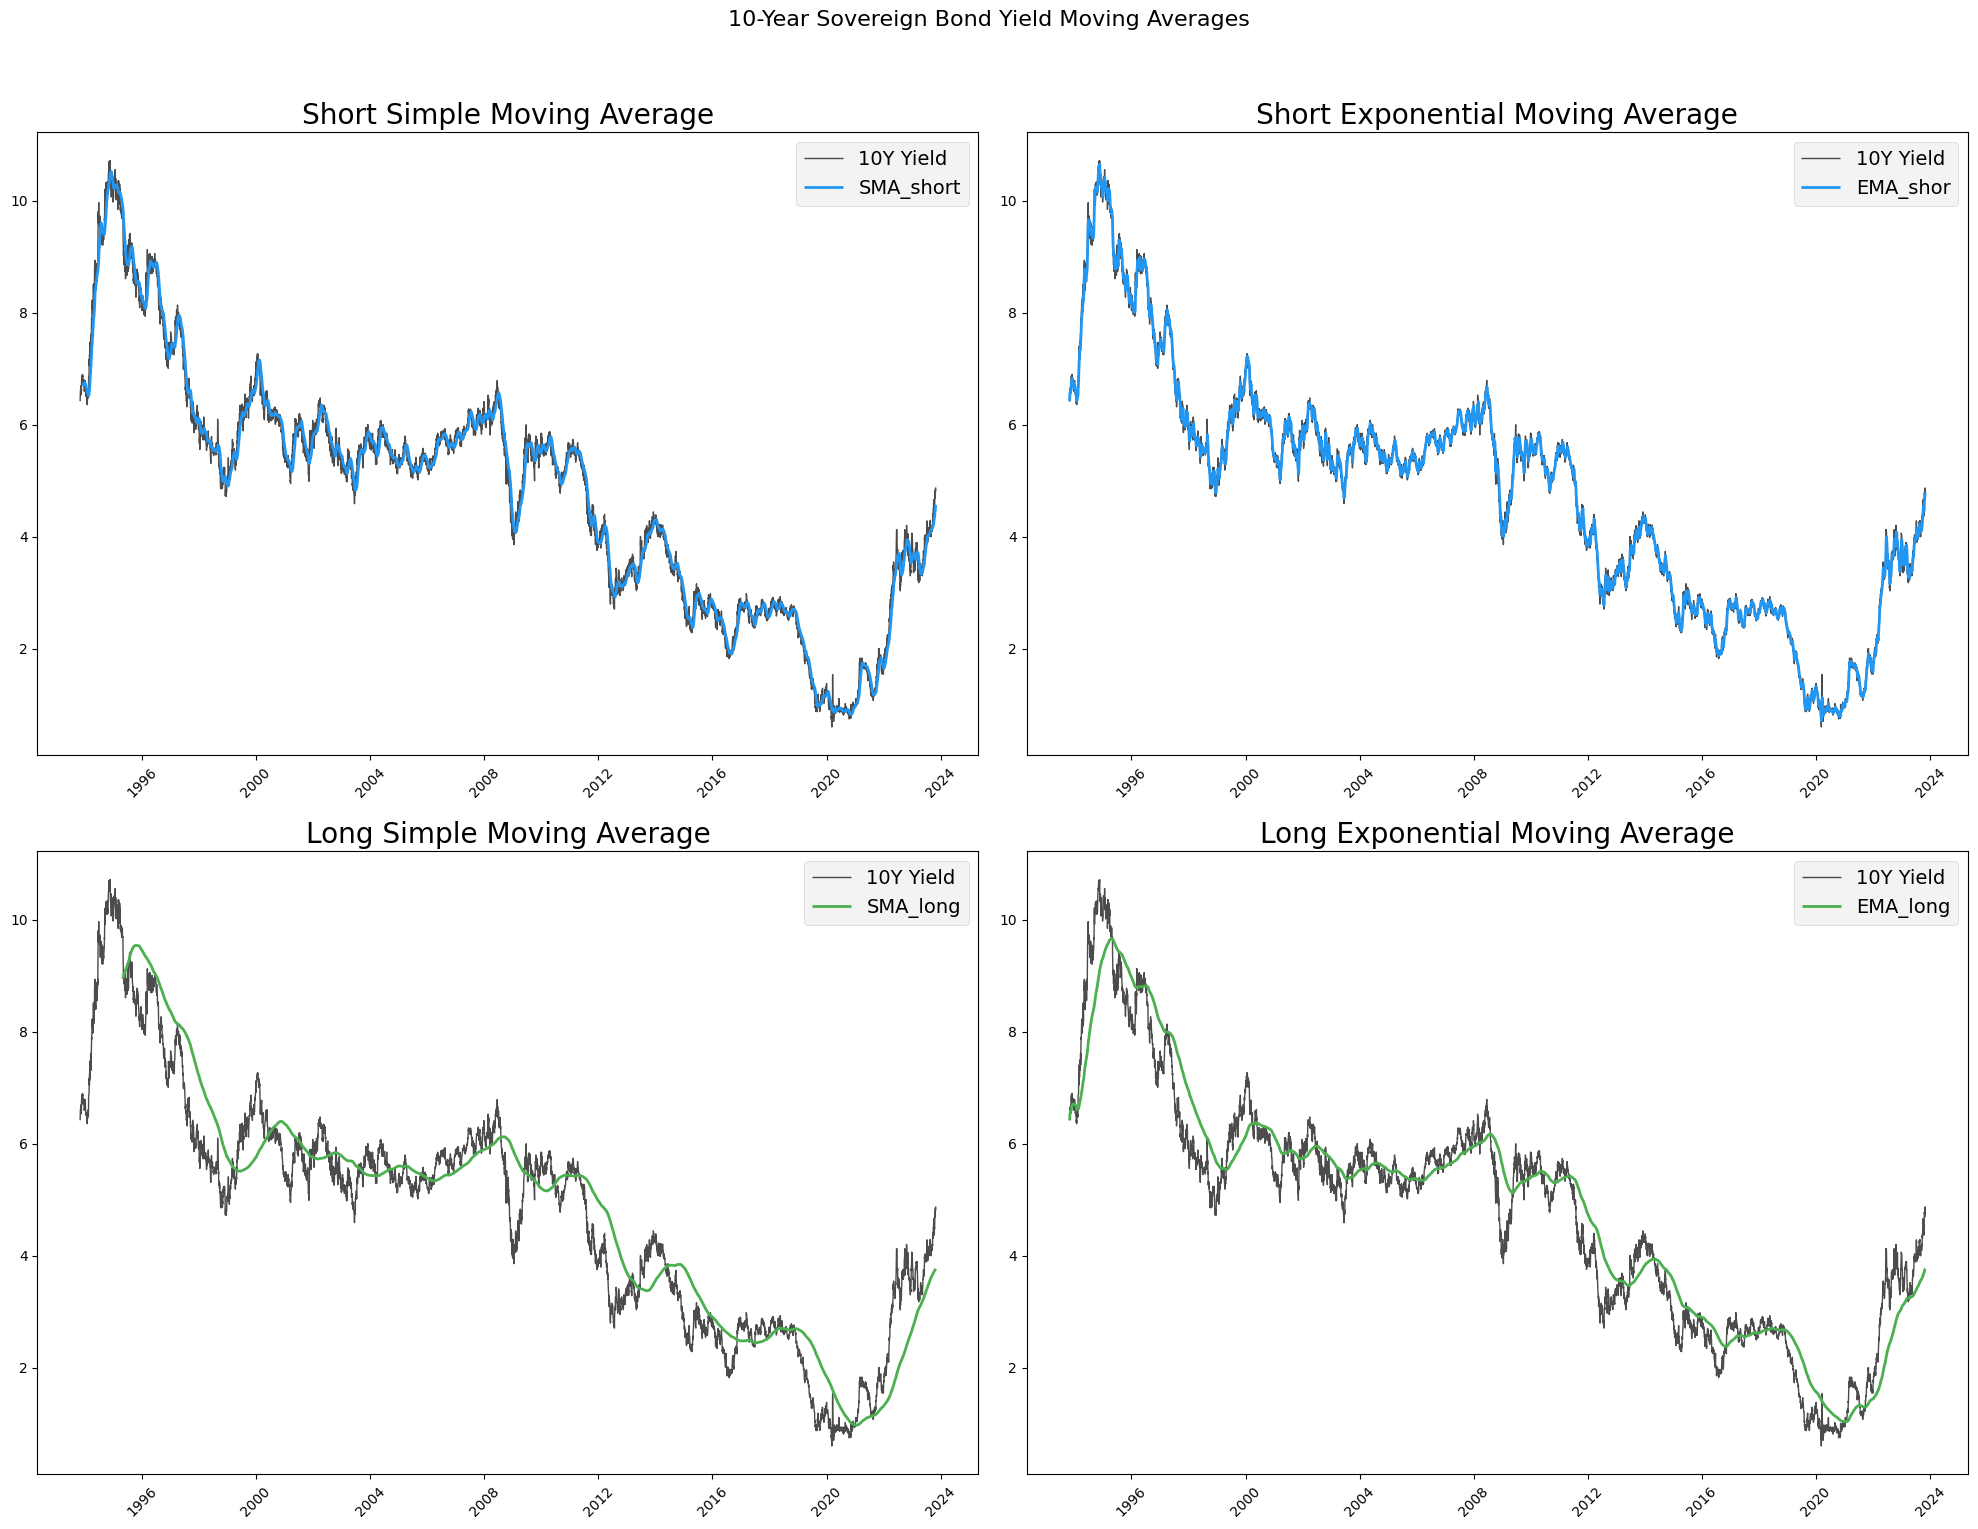

In [234]:
# creating figures and subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.style.use('fivethirtyeight')

axes = axes.flatten()

# sma short
axes[0].plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[0].plot(df_indicators.index, df_indicators['SMA_short'], label='SMA_short', color='#2196F3', linewidth=2)
axes[0].set_title('Short Simple Moving Average')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# ema short
axes[1].plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[1].plot(df_indicators.index, df_indicators['EMA_short'], label='EMA_shor', color='#2196F3', linewidth=2)
axes[1].set_title('Short Exponential Moving Average')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# sma long
axes[2].plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[2].plot(df_indicators.index, df_indicators['SMA_long'], label='SMA_long', color='#4CAF50', linewidth=2)
axes[2].set_title('Long Simple Moving Average')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

# ema long
axes[3].plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
axes[3].plot(df_indicators.index, df_indicators['EMA_long'], label='EMA_long', color='#4CAF50', linewidth=2)
axes[3].set_title('Long Exponential Moving Average')
axes[3].legend()
axes[3].tick_params(axis='x', rotation=45)

fig.suptitle('10-Year Sovereign Bond Yield Moving Averages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

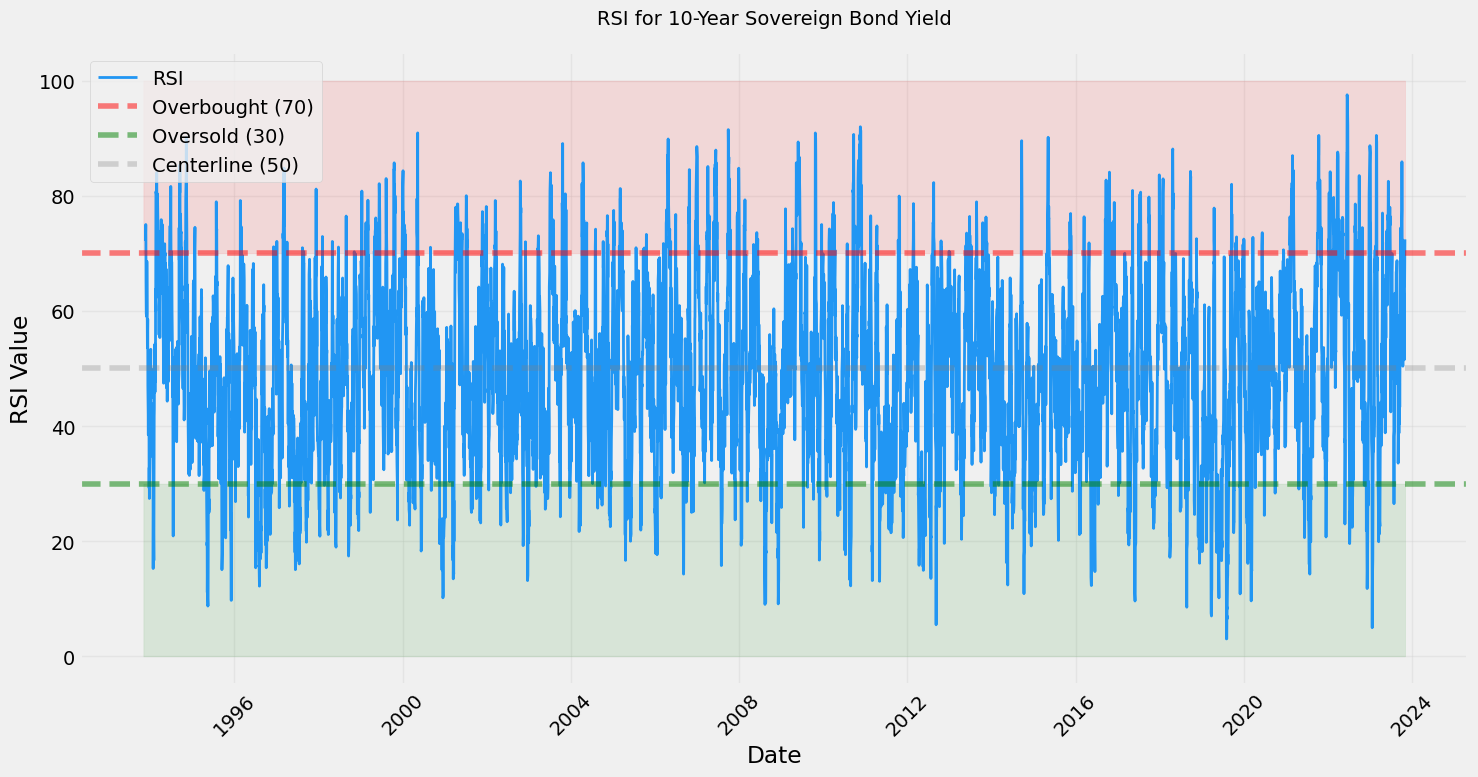

In [235]:
# plot rsi
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')
plt.plot(df_indicators.index, df_indicators['RSI'], color='#2196F3', linewidth=2, label='RSI')
plt.title('RSI for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.ylabel('RSI Value')
plt.xlabel('Date')

plt.axhline(y=70, color='r', linestyle='--', alpha=0.5, label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.5, label='Oversold (30)')
plt.axhline(y=50, color='gray', linestyle='--', alpha=0.3, label='Centerline (50)')

plt.fill_between(df_indicators.index, 70, 100, color='r', alpha=0.1)
plt.fill_between(df_indicators.index, 0, 30, color='g', alpha=0.1)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

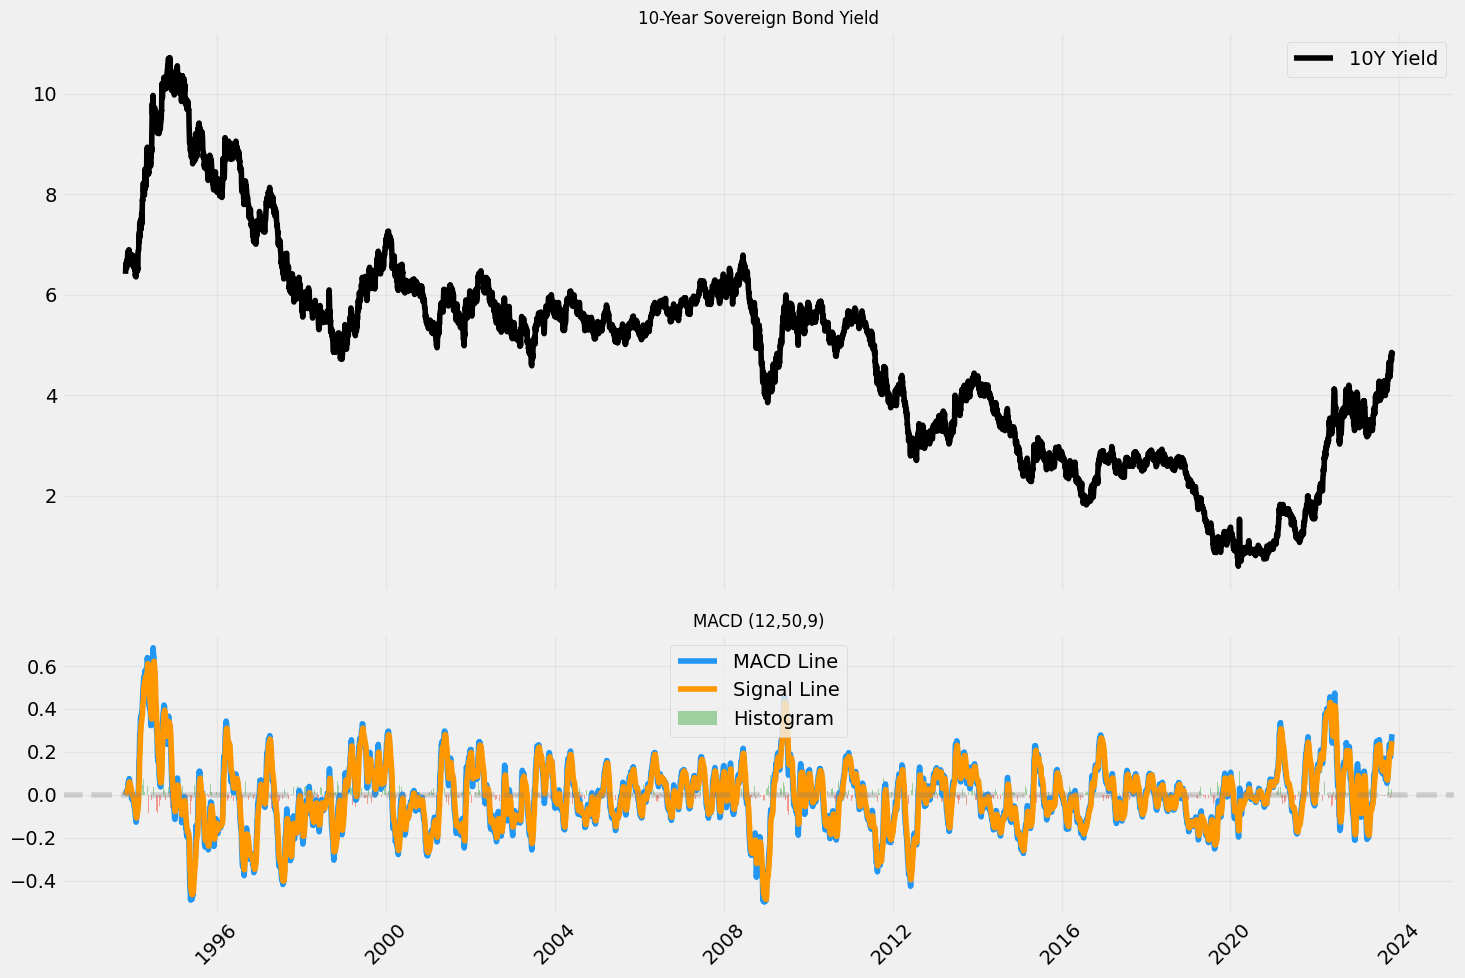

In [236]:
# MACD plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1], sharex=True)
plt.style.use('fivethirtyeight')
ax1.plot(df_indicators.index, df_indicators['yield_10y'], color='black', label='10Y Yield')
ax1.set_title('10-Year Sovereign Bond Yield', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# macd signal line at 9 days ewm
macd_signal = df_indicators['MACD'].ewm(span=9, adjust=False).mean()
macd_hist = df_indicators['MACD'] - macd_signal
ax2.plot(df_indicators.index, df_indicators['MACD'], color='#2196F3', label='MACD Line')
ax2.plot(df_indicators.index, macd_signal, color='#FF9800', label='Signal Line')
colors = ['#4CAF50' if val >= 0 else '#F44336' for val in macd_hist]
ax2.bar(df_indicators.index, macd_hist, color=colors, label='Histogram', alpha=0.5)
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
ax2.set_title(f"MACD ({best_params['MACD_fast']},{best_params['MACD_slow']},9)", fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

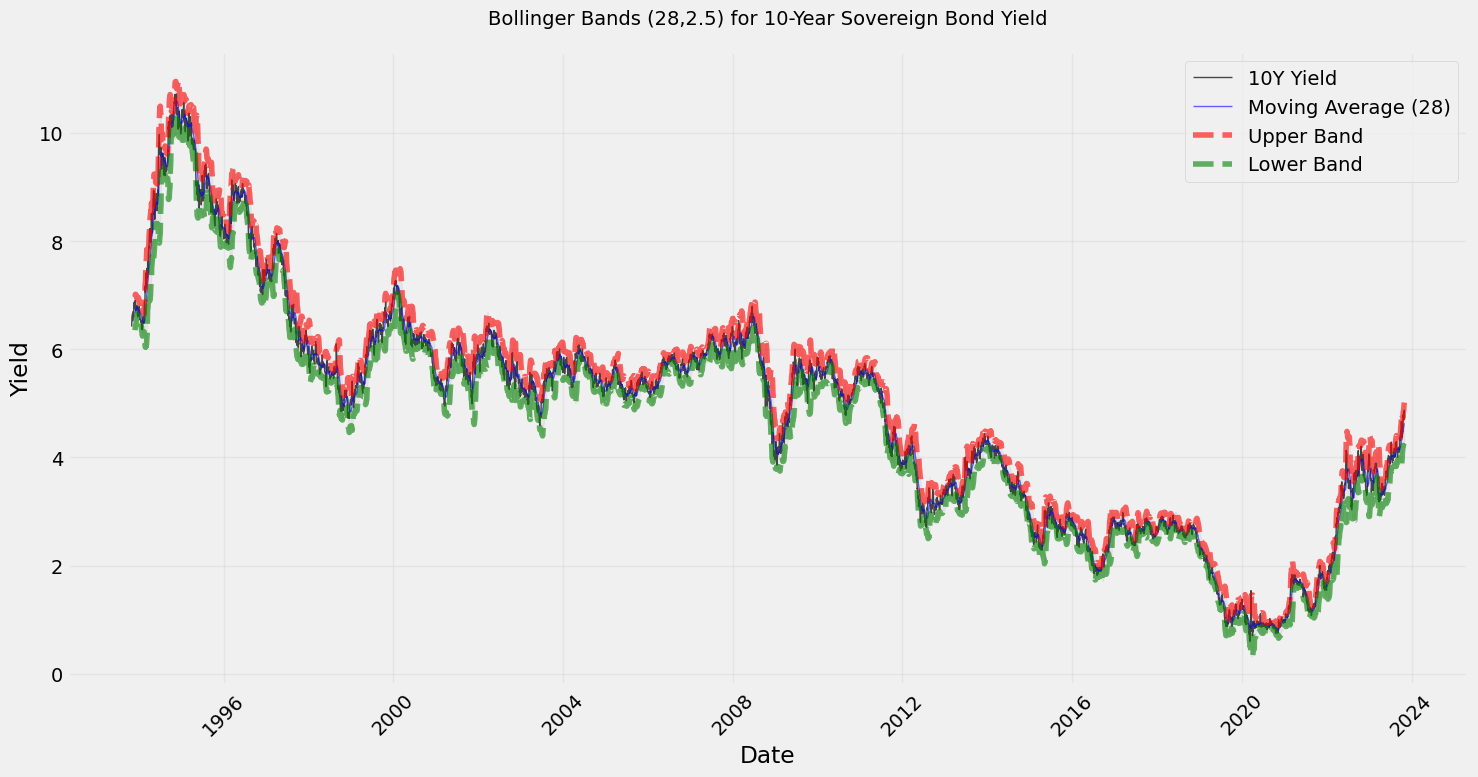

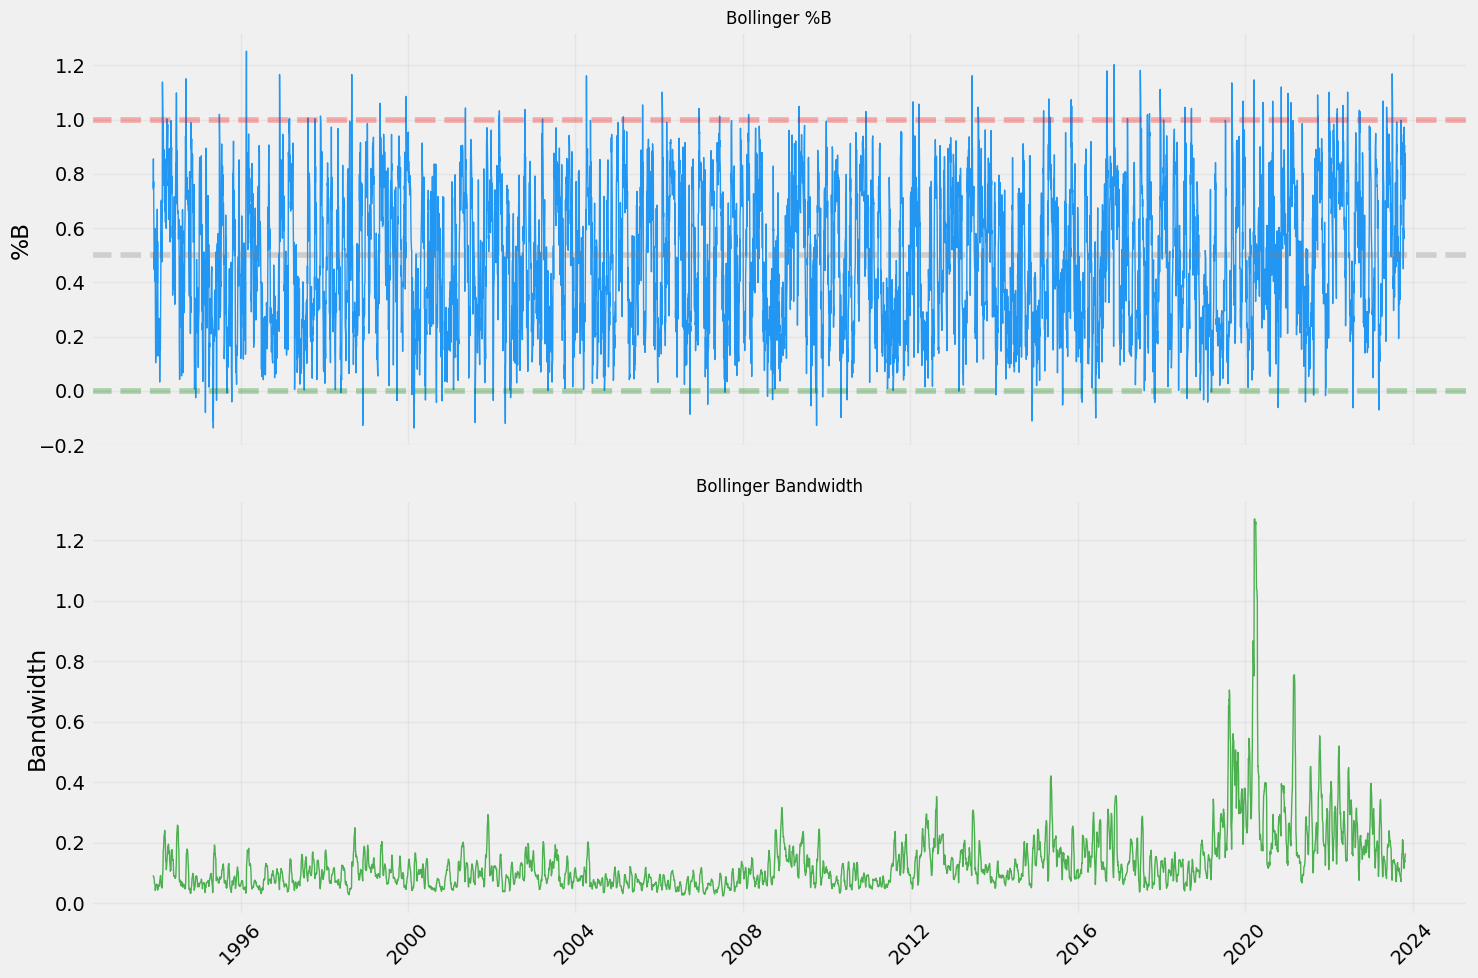

In [237]:
# bollinger bands plot
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')
plt.plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', alpha=0.7, linewidth=1)
plt.plot(df_indicators.index, bb_middle, label=f'Moving Average ({best_params["SMA_short"]})', color='blue', alpha=0.6, linewidth=1)
plt.plot(df_indicators.index, df_indicators['BB_upper'], label='Upper Band', color='red', linestyle='--', alpha=0.6)
plt.plot(df_indicators.index, df_indicators['BB_lower'], label='Lower Band', color='green', linestyle='--', alpha=0.6)
plt.fill_between(df_indicators.index, df_indicators['BB_upper'], df_indicators['BB_lower'], alpha=0.1, color='gray')

plt.title(f'Bollinger Bands ({best_params["SMA_short"]},{best_params["BB_std_dev"]}) for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Yield')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# bb bandwidth
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
pband = (df_indicators['yield_10y'] - df_indicators['BB_lower']) / (df_indicators['BB_upper'] - df_indicators['BB_lower'])
wband = (df_indicators['BB_upper'] - df_indicators['BB_lower']) / bb_middle


ax1.plot(df_indicators.index, pband, color='#2196F3', linewidth=1)
ax1.axhline(y=1, color='red', linestyle='--', alpha=0.3)
ax1.axhline(y=0, color='green', linestyle='--', alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
ax1.set_title('Bollinger %B', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('%B')


ax2.plot(df_indicators.index, wband, color='#4CAF50', linewidth=1)
ax2.set_title('Bollinger Bandwidth', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylabel('Bandwidth')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

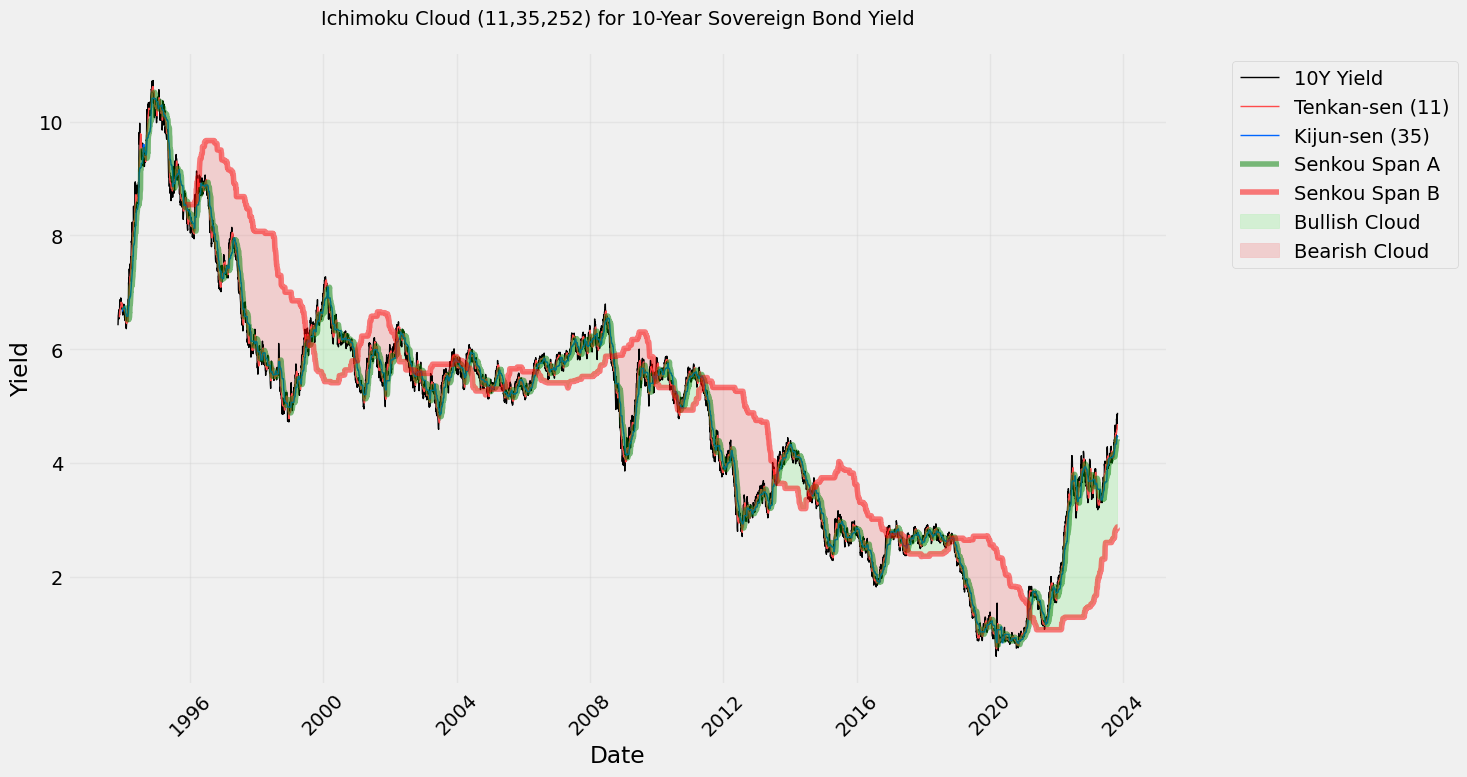

In [238]:
# ichimoku kinko hyo lines plot
plt.figure(figsize=(15, 8))
plt.style.use('fivethirtyeight')
plt.plot(df_indicators.index, df_indicators['yield_10y'], label='10Y Yield', color='black', linewidth=1)


plt.plot(df_indicators.index, df_indicators['Ichimoku_Tenkan'], label=f"Tenkan-sen ({best_params['Ichimoku_Tenkan']})", color='#FF4B4B', linewidth=1)
plt.plot(df_indicators.index, df_indicators['Ichimoku_Kijun'], label=f"Kijun-sen ({best_params['Ichimoku_Kijun']})", color='#0066FF', linewidth=1)

# getting teh clouds
senkou_span_a = ((df_indicators['Ichimoku_Tenkan'] + df_indicators['Ichimoku_Kijun']) / 2).shift(best_params['Ichimoku_Tenkan'])

# long cloud
senkou_span_b = df_indicators['Ichimoku_SenkouB'].shift(best_params['Ichimoku_SenkouB'])

plt.plot(df_indicators.index, senkou_span_a, label='Senkou Span A', color='green', alpha=0.5)
plt.plot(df_indicators.index, senkou_span_b, label='Senkou Span B', color='red', alpha=0.5)

plt.fill_between(df_indicators.index, 
                senkou_span_a, 
                senkou_span_b, 
                where=senkou_span_a >= senkou_span_b, 
                color='lightgreen', 
                alpha=0.3,
                label='Bullish Cloud')

plt.fill_between(df_indicators.index, 
                senkou_span_a, 
                senkou_span_b, 
                where=senkou_span_a < senkou_span_b, 
                color='lightcoral', 
                alpha=0.3,
                label='Bearish Cloud')


plt.title(f'Ichimoku Cloud ({best_params["Ichimoku_Tenkan"]},{best_params["Ichimoku_Kijun"]},{best_params["Ichimoku_SenkouB"]}) for 10-Year Sovereign Bond Yield', fontsize=14, pad=20)
plt.xlabel('Date')
plt.ylabel('Yield')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Final df used for model fitting

In [239]:
df_indicators = df_indicators.dropna()
df_indicators

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

            yield_10y        RSI  SMA_short  SMA_long  EMA_short  EMA_long  \
Date                                                                         
1995-05-02      9.700  40.579710   9.898929  8.947507   9.734039  9.664700   
1995-05-03      9.680  32.812500   9.881071  8.956438   9.720529  9.664811   
1995-05-04      9.470  28.000000   9.851429  8.964575   9.657897  9.663394   
1995-05-05      9.380  25.609756   9.821071  8.972329   9.588423  9.661334   
1995-05-08      9.100  19.266055   9.781786  8.979205   9.466317  9.657256   
...               ...        ...        ...       ...        ...       ...   
2023-10-24      4.693  51.505376   4.476429  3.752022   4.680153  3.739897   
2023-10-25      4.736  58.783784   4.499214  3.755414   4.694115  3.746515   
2023-10-26      4.856  64.717742   4.522250  3.759263   4.734586  3.753887   
2023-10-27      4.814  64.328657   4.544929  3.763178   4.754440  3.760931   
2023-10-30      4.881  72.420838   4.568143  3.767329   4.786080

In [240]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7060 entries, 1995-05-02 to 2023-10-30
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   yield_10y         7060 non-null   float64
 1   RSI               7060 non-null   float64
 2   SMA_short         7060 non-null   float64
 3   SMA_long          7060 non-null   float64
 4   EMA_short         7060 non-null   float64
 5   EMA_long          7060 non-null   float64
 6   MACD              7060 non-null   float64
 7   BB_upper          7060 non-null   float64
 8   BB_lower          7060 non-null   float64
 9   BB_width          7060 non-null   float64
 10  Ichimoku_Tenkan   7060 non-null   float64
 11  Ichimoku_Kijun    7060 non-null   float64
 12  Ichimoku_SenkouB  7060 non-null   float64
 13  Volatility        7060 non-null   float64
 14  MOM               7060 non-null   float64
 15  Yield_Change      7060 non-null   float64
 16  Yield_Change_5d   7060 n

In [241]:
df_macro_imputed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10956 entries, 1993-11-01 to 2023-10-30
Freq: D
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   inflation          10956 non-null  float64
 1   ppi_mom            10956 non-null  float64
 2   fed_funds_rate     10956 non-null  float64
 3   unemployment_rate  10956 non-null  float64
 4   10_minus_2         10956 non-null  float64
 5   gdp                10956 non-null  float64
dtypes: float64(6)
memory usage: 857.2 KB


In [242]:
df_marco_merge_final = df_indicators.join(df_macro_imputed, how='left')
df_marco_merge_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7060 entries, 1995-05-02 to 2023-10-30
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   yield_10y          7060 non-null   float64
 1   RSI                7060 non-null   float64
 2   SMA_short          7060 non-null   float64
 3   SMA_long           7060 non-null   float64
 4   EMA_short          7060 non-null   float64
 5   EMA_long           7060 non-null   float64
 6   MACD               7060 non-null   float64
 7   BB_upper           7060 non-null   float64
 8   BB_lower           7060 non-null   float64
 9   BB_width           7060 non-null   float64
 10  Ichimoku_Tenkan    7060 non-null   float64
 11  Ichimoku_Kijun     7060 non-null   float64
 12  Ichimoku_SenkouB   7060 non-null   float64
 13  Volatility         7060 non-null   float64
 14  MOM                7060 non-null   float64
 15  Yield_Change       7060 non-null   float64
 16  Yield_

In [243]:
df_marco_merge_final.isna().sum()

yield_10y            0
RSI                  0
SMA_short            0
SMA_long             0
EMA_short            0
EMA_long             0
MACD                 0
BB_upper             0
BB_lower             0
BB_width             0
Ichimoku_Tenkan      0
Ichimoku_Kijun       0
Ichimoku_SenkouB     0
Volatility           0
MOM                  0
Yield_Change         0
Yield_Change_5d      0
Yield_Change_20d     0
inflation            0
ppi_mom              0
fed_funds_rate       0
unemployment_rate    0
10_minus_2           0
gdp                  0
dtype: int64

## hypothesis testing for indicators

In [244]:
# testing each individual feature for relevance
relevant_features = []
target_var = 'yield_10y'
col_list = df_marco_merge_final.columns.to_list()
features = [item for item in col_list if item != target_var]
print(features)

['RSI', 'SMA_short', 'SMA_long', 'EMA_short', 'EMA_long', 'MACD', 'BB_upper', 'BB_lower', 'BB_width', 'Ichimoku_Tenkan', 'Ichimoku_Kijun', 'Ichimoku_SenkouB', 'Volatility', 'MOM', 'Yield_Change', 'Yield_Change_5d', 'Yield_Change_20d', 'inflation', 'ppi_mom', 'fed_funds_rate', 'unemployment_rate', '10_minus_2', 'gdp']


In [245]:
technical_indicators = ['RSI', 'SMA_short', 'SMA_long', 'EMA_short', 'EMA_long', 'MACD', 'BB_upper', 'BB_lower', 'BB_width', 'Ichimoku_Tenkan', 'Ichimoku_Kijun', 'Ichimoku_SenkouB']

yield_based_indicators = ['Yield_Change', 'Yield_Change_5d', 'Yield_Change_20d']

macro_indicators = ['inflation', 'ppi_mom', 'fed_funds_rate', 'unemployment_rate', '10_minus_2', 'gdp']

In [246]:
relevant_features = set()

# granger_causality_test to test indicator hypothesis for technical indicators
def granger_causality_test(df, target_var, feature, maxlag=365):
    try:
        data = df[[target_var, feature]].dropna()
        gc_result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
        for lag, test_results in gc_result.items():
            ftest_pvalue = test_results[0]['ssr_ftest'][1]
            if ftest_pvalue < 0.05:
                relevant_features.add(feature)
                break
    except Exception as e:
        print(f"Error testing {feature}: {e}")

In [247]:
print("\n--- Technical Indicators ---")
# Ran this and it took 26 minutes to run relevancy of all the indicators and resulted out all the techinical indicators as relevant.
# To save time for next runs, just setting this to list of all technical indicators
#==========================================================================================
# for feature in technical_indicators:
#     granger_causality_test(df_marco_merge_final, target_var=target_var, feature=feature)
#==========================================================================================

relevant_features_list = technical_indicators
print("\nRelevant Features:", relevant_features_list)


--- Technical Indicators ---

Relevant Features: ['RSI', 'SMA_short', 'SMA_long', 'EMA_short', 'EMA_long', 'MACD', 'BB_upper', 'BB_lower', 'BB_width', 'Ichimoku_Tenkan', 'Ichimoku_Kijun', 'Ichimoku_SenkouB']


In [248]:
# run a simple ols linear regression for yield based indicators
def linear_regression(df, target_var, features, significance_level=0.05):
    significant_features = []
    
    for feature in features:
        try:
            y = df[target_var].dropna()
            x = df[feature].dropna()
            common_index = y.index.intersection(x.index)
            
            if len(common_index) < 2:
                continue
                
            y_aligned = y.loc[common_index]
            x_aligned = x.loc[common_index]
            
            X = sm.add_constant(x_aligned)
            
            model = sm.OLS(y_aligned, X)
            results = model.fit()
            
            if results.pvalues[1] < significance_level:
                significant_features.append(feature)
                
        except Exception as e:
            print(f"Error analyzing {feature}: {e}")
    
    return significant_features


relevant_yield_features = linear_regression(df_marco_merge_final, target_var=target_var, features=yield_based_indicators, significance_level=0.05)

print("\nRelevant Yield Features:", relevant_yield_features)


Relevant Yield Features: []


In [249]:
# cointegration tests for macro variables
def cointegration_tests(df, target_var, features, significance_level=0.05, max_lags=63):
    cointegrated_features = []

    target_data = df[target_var].dropna()
    target_adf = adfuller(target_data)[1]
    
    print(f"\nStationarity test for {target_var}: p-value {target_adf}")
    if target_adf > 0.05:
        print("Target Var is not stationary")
    
    for feature in features:
        try:
            feature_data = df[feature].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(feature_data) < 30:
                print(f"Insufficient data for {feature}")
                continue
            
            min_pvalue = float('inf')
            best_lag = 0
            
            for lag in range(max_lags + 1):
                if lag > 0:
                    lagged_feature = feature_data.shift(lag)
                else:
                    lagged_feature = feature_data
                
                common_index = target_data.index.intersection(lagged_feature.index)
                y_aligned = target_data.loc[common_index]
                x_aligned = lagged_feature.loc[common_index]
                
                valid_idx = ~(np.isnan(y_aligned) | np.isnan(x_aligned) | 
                            np.isinf(y_aligned) | np.isinf(x_aligned))
                y_aligned = y_aligned[valid_idx]
                x_aligned = x_aligned[valid_idx]
                
                if len(y_aligned) < 30:
                    continue
                
                _, p_value, _ = coint(y_aligned, x_aligned)
                
                if not np.isnan(p_value) and p_value < min_pvalue:
                    min_pvalue = p_value
                    best_lag = lag
            
            if min_pvalue < significance_level:
                cointegrated_features.append(feature)
                print(f"{feature}: Cointegrated at lag {best_lag} with p-value {min_pvalue:.4f}")
            else:
                print(f"{feature}: Not cointegrated. Best p-value {min_pvalue:.4f} at lag {best_lag}")
                
        except Exception as e:
            print(f"Error analyzing {feature}: {str(e)}")
    
    return cointegrated_features

cointegrated_features = cointegration_tests(df_marco_merge_final, target_var, features=macro_indicators)
print("Cointegrated features:", cointegrated_features)


Stationarity test for yield_10y: p-value 0.11411346921338189
Target Var is not stationary
inflation: Not cointegrated. Best p-value 0.1902 at lag 0
ppi_mom: Not cointegrated. Best p-value 0.2398 at lag 60
fed_funds_rate: Cointegrated at lag 45 with p-value 0.0012
unemployment_rate: Not cointegrated. Best p-value 0.2465 at lag 58
10_minus_2: Not cointegrated. Best p-value 0.2477 at lag 58
gdp: Not cointegrated. Best p-value 0.2083 at lag 0
Cointegrated features: ['fed_funds_rate']


### We find that other macro variables are not significant indiactors as our data is on a daily basis and our hypothesis is that since teh other factors are monthly or quarterly the variance with daily change is not same as quarterly or monthly. Like if we make the confidence level to 25% then some macros become significant.

In [250]:
def volatility_significance_tests(df, target_var, features):
    y = df[target_var].dropna()
    vol = df[features].dropna()

    common_index = y.index.intersection(vol.index)
    y_aligned = y.loc[common_index]
    vol_aligned = vol.loc[common_index]

    arima_model = ARIMA(y_aligned, order=(1, 0, 0)).fit()
    residuals = arima_model.resid.dropna()

    garch = arch_model(residuals, vol='Garch', p=1, o=0, q=1, x=vol_aligned.to_frame())
    garch_res = garch.fit(disp='off')

    print(garch_res.summary())

    volatility_param = None
    for param_name in garch_res.params.index:
        if param_name.startswith('x'):
            volatility_param = param_name
            break

    if volatility_param is not None:
        coef = garch_res.params[volatility_param]
        pvalue = garch_res.pvalues[volatility_param]
        print(f"\nVolatility coefficient: {coef:.4f}")
        print(f"P-value: {pvalue:.4f}")
        
        if pvalue < 0.05:
            print("The volatility effect is statistically significant at the 5% level")
        else:
            print("The volatility effect is not statistically significant at the 5% level")
    else:
        print("\nNo exogenous variable coefficient found in the model results")

In [251]:
volatility_significance_tests(df_marco_merge_final, target_var, 'Volatility')

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9682.26
Distribution:                  Normal   AIC:                          -19356.5
Method:            Maximum Likelihood   BIC:                          -19329.1
                                        No. Observations:                 7060
Date:                Sat, Dec 21 2024   Df Residuals:                     7059
Time:                        22:08:51   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.4725e-03  5.986e-04     -2.460  1.3

In [252]:
## Just getting indicators which passed the respective hypothesis tests
final_indicators = technical_indicators + relevant_yield_features + cointegrated_features + [target_var]
final_indicators

['RSI',
 'SMA_short',
 'SMA_long',
 'EMA_short',
 'EMA_long',
 'MACD',
 'BB_upper',
 'BB_lower',
 'BB_width',
 'Ichimoku_Tenkan',
 'Ichimoku_Kijun',
 'Ichimoku_SenkouB',
 'fed_funds_rate',
 'yield_10y']

In [253]:
df_analysis = df_marco_merge_final[final_indicators]
df_analysis.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

                  RSI  SMA_short  SMA_long  EMA_short  EMA_long      MACD  \
1995-05-02  40.579710   9.898929  8.947507   9.734039  9.664700 -0.192482   
1995-05-03  32.812500   9.881071  8.956438   9.720529  9.664811 -0.194833   
1995-05-04  28.000000   9.851429  8.964575   9.657897  9.663394 -0.219641   
1995-05-05  25.609756   9.821071  8.972329   9.588423  9.661334 -0.248801   
1995-05-08  19.266055   9.781786  8.979205   9.466317  9.657256 -0.303102   

             BB_upper  BB_lower  BB_width  Ichimoku_Tenkan  Ichimoku_Kijun  \
1995-05-02   9.962634  9.617366  0.035267            9.775           9.995   
1995-05-03   9.963846  9.601154  0.037076            9.770           9.990   
1995-05-04  10.000641  9.521359  0.049102            9.665           9.885   
1995-05-05  10.059024  9.420976  0.065508            9.620           9.840   
1995-05-08  10.176516  9.229484  0.097602            9.480           9.700   

            Ichimoku_SenkouB  fed_funds_rate  yield_10y  
1995-05-02

# 3) Feature Selection

In [254]:
y = df_analysis[target_var]
X = df_analysis.drop(columns=[target_var])

In [255]:
# generating expanding windows
splits = []
n_samples = len(X)
initial_train_size = int(n_samples * 0.1)
max_train_size = int(n_samples * 0.6)
step_size = 365

for train_end in range(initial_train_size, max_train_size, step_size):
    train_idx = np.arange(train_end)
    test_idx = np.arange(train_end, min(train_end + step_size, n_samples))
    splits.append((train_idx, test_idx))

print(f"Created {len(splits)} time windows")

Created 10 time windows


In [256]:
# feature importance dicts
feature_importance_dict = {feature: [] for feature in X.columns}
all_selected_features = pd.DataFrame(index=X.columns)

In [257]:
lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

In [258]:
# running feature selection in expanding windows
for i, (train_idx, test_idx) in enumerate(splits):
    print(f"\nProcessing window {i+1}/{len(splits)}")
    print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    
    # standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    
    # Lrunniing lasso regression
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    lasso_scores = dict(zip(X_train.columns, np.abs(lasso.coef_)))
    
    # running a lightgbm model
    train_data = lgb.Dataset(X_train_scaled, label=y_train)
    lgb_model = lgb.train(lgb_params, train_data, num_boost_round=100)
    lgb_importance = dict(zip(X_train.columns, lgb_model.feature_importance(importance_type='gain')))
    
    # normalizing scorews
    lasso_scores = {k: v/max(lasso_scores.values()) for k, v in lasso_scores.items()}
    lgb_importance = {k: v/max(lgb_importance.values()) for k, v in lgb_importance.items()}
    
    # combining scores
    combined_scores = {feature: (lasso_scores[feature] + lgb_importance[feature])/2 for feature in X_train.columns}
    
    # selecting features with  significance threshold = 0.0002
    selected_features = [feature for feature, score in combined_scores.items() if score >= 0.0002]
    
    print(f"Selected {len(selected_features)} features in this window")
    
    # storing selected features for each window
    window_size = len(train_idx)
    all_selected_features[f'Window_{window_size}'] = [ 1 if col in selected_features else 0 for col in X.columns]
    
    # storing importance scores
    for feature, score in combined_scores.items():
        feature_importance_dict[feature].append(score)


Processing window 1/10
Train size: 706, Test size: 365
Selected 12 features in this window

Processing window 2/10
Train size: 1071, Test size: 365
Selected 12 features in this window

Processing window 3/10
Train size: 1436, Test size: 365
Selected 10 features in this window

Processing window 4/10
Train size: 1801, Test size: 365
Selected 9 features in this window

Processing window 5/10
Train size: 2166, Test size: 365
Selected 11 features in this window

Processing window 6/10
Train size: 2531, Test size: 365
Selected 11 features in this window

Processing window 7/10
Train size: 2896, Test size: 365
Selected 11 features in this window

Processing window 8/10
Train size: 3261, Test size: 365
Selected 10 features in this window

Processing window 9/10
Train size: 3626, Test size: 365
Selected 9 features in this window

Processing window 10/10
Train size: 3991, Test size: 365
Selected 11 features in this window


In [259]:
# calculating teh average importance across all windows
final_importance = {feature: np.mean(scores) for feature, scores in feature_importance_dict.items()}

# getting stable features which are significant 50% of teh time
feature_stability = all_selected_features.mean(axis=1)
final_features = list(feature_stability[feature_stability >= 0.5].index)

In [260]:
# creating importance dataframe
importance_df = pd.DataFrame({
    'Feature': final_importance.keys(),
    'Average_Importance': final_importance.values(),
    'Selection_Stability': feature_stability.values,
    'Selected': [1 if feat in final_features else 0 for feat in final_importance.keys()]
})
importance_df = importance_df.sort_values('Average_Importance', ascending=False)

print(importance_df.head(20))

print(f"\nFinal Selected Features ({len(final_features)}):")
print(final_features)

             Feature  Average_Importance  Selection_Stability  Selected
3          EMA_short            0.976267                  1.0         1
9    Ichimoku_Tenkan            0.089362                  1.0         1
2           SMA_long            0.058590                  1.0         1
1          SMA_short            0.056907                  1.0         1
4           EMA_long            0.041446                  0.8         1
0                RSI            0.031213                  1.0         1
10    Ichimoku_Kijun            0.008617                  0.8         1
11  Ichimoku_SenkouB            0.004298                  0.5         1
6           BB_upper            0.004143                  0.8         1
12    fed_funds_rate            0.002628                  1.0         1
8           BB_width            0.000571                  0.7         1
5               MACD            0.000416                  0.4         0
7           BB_lower            0.000362                  0.6   

In [261]:
# shorten data for selected features
final_vars = final_features + [target_var]
df_final_regime = df_analysis[final_vars]
df_final_regime

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\formatters.py", line 344, in __call__
    return method()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py", line 1106, in _repr_html_
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\format.py", line 1110, in to_html
    When formatting an Index subclass
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 88, in to_string
    lines = self.render()
  File "c:\Users\Krish\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\formats\html.py", line 644, in render
    super().render()
  File "c:\Users\Krish\Ap

                  RSI  SMA_short  SMA_long  EMA_short  EMA_long   BB_upper  \
1995-05-02  40.579710   9.898929  8.947507   9.734039  9.664700   9.962634   
1995-05-03  32.812500   9.881071  8.956438   9.720529  9.664811   9.963846   
1995-05-04  28.000000   9.851429  8.964575   9.657897  9.663394  10.000641   
1995-05-05  25.609756   9.821071  8.972329   9.588423  9.661334  10.059024   
1995-05-08  19.266055   9.781786  8.979205   9.466317  9.657256  10.176516   
...               ...        ...       ...        ...       ...        ...   
2023-10-24  51.505376   4.476429  3.752022   4.680153  3.739897   4.879680   
2023-10-25  58.783784   4.499214  3.755414   4.694115  3.746515   4.892999   
2023-10-26  64.717742   4.522250  3.759263   4.734586  3.753887   4.940429   
2023-10-27  64.328657   4.544929  3.763178   4.754440  3.760931   4.971690   
2023-10-30  72.420838   4.568143  3.767329   4.786080  3.768374   5.014565   

            BB_lower  BB_width  Ichimoku_Tenkan  Ichimoku_Kijun

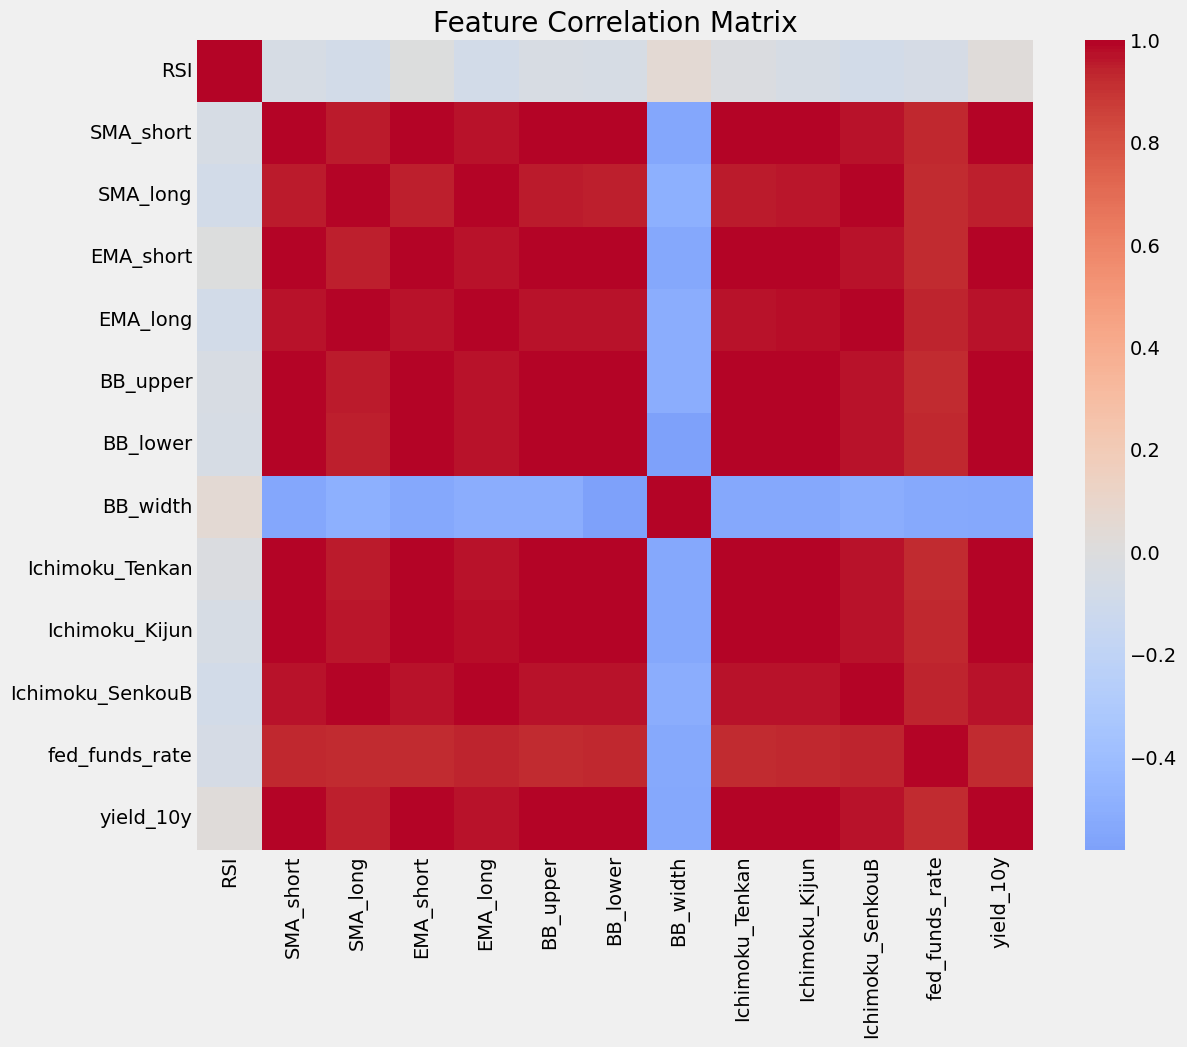

Highly correlated feature pairs: [('SMA_short', 'fed_funds_rate'), ('SMA_short', 'yield_10y'), ('SMA_long', 'SMA_short'), ('SMA_long', 'fed_funds_rate'), ('SMA_long', 'yield_10y'), ('EMA_short', 'SMA_short'), ('EMA_short', 'SMA_long'), ('EMA_short', 'Ichimoku_Tenkan'), ('EMA_short', 'Ichimoku_Kijun'), ('EMA_short', 'Ichimoku_SenkouB'), ('EMA_short', 'fed_funds_rate'), ('EMA_short', 'yield_10y'), ('EMA_long', 'SMA_short'), ('EMA_long', 'SMA_long'), ('EMA_long', 'EMA_short'), ('EMA_long', 'Ichimoku_Tenkan'), ('EMA_long', 'Ichimoku_Kijun'), ('EMA_long', 'Ichimoku_SenkouB'), ('EMA_long', 'fed_funds_rate'), ('EMA_long', 'yield_10y'), ('BB_upper', 'SMA_short'), ('BB_upper', 'SMA_long'), ('BB_upper', 'EMA_short'), ('BB_upper', 'EMA_long'), ('BB_upper', 'Ichimoku_Tenkan'), ('BB_upper', 'Ichimoku_Kijun'), ('BB_upper', 'Ichimoku_SenkouB'), ('BB_upper', 'fed_funds_rate'), ('BB_upper', 'yield_10y'), ('BB_lower', 'SMA_short'), ('BB_lower', 'SMA_long'), ('BB_lower', 'EMA_short'), ('BB_lower', 'EMA_l

In [262]:
# plotting the feature correlation matrix
corr = df_final_regime.corr()

# plot correlation matrix amongst features
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

high_corr_pairs = [(c1, c2) for c1 in corr.columns for c2 in corr.columns if c1 < c2 and abs(corr.loc[c1, c2]) > 0.9]
print("Highly correlated feature pairs:", high_corr_pairs)

# 4) Regime Modeling

## Now using hidden markov models for regime detection

In [263]:
# features for HMM
df_final_regime['returns'] = df_final_regime['yield_10y'].pct_change()
df_final_regime['rolling_vol'] = df_final_regime['returns'].rolling(window=21).std()
df_final_regime['annualized_vol'] = df_final_regime['rolling_vol'] * np.sqrt(252)

# dropping nan values
df_final_regime = df_final_regime.dropna(subset=['returns', 'rolling_vol', 'annualized_vol'])

In [264]:
X_hmm = df_final_regime[['returns', 'annualized_vol']].values

In [265]:
# fitting hmm with 2 states
model_hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000, random_state=42)
model_hmm.fit(X_hmm)

# predicting hidden states
hidden_states = model_hmm.predict(X_hmm)
df_final_regime['hidden_state'] = hidden_states

state_vol_means = []
for state in range(model_hmm.n_components):
    mask = (df_final_regime['hidden_state'] == state)
    state_vol_mean = df_final_regime.loc[mask, 'annualized_vol'].mean()
    state_vol_means.append((state, state_vol_mean))

In [266]:
# sorting states by volatilioty mean
state_vol_means.sort(key=lambda x: x[1])
low_state = state_vol_means[0][0]
high_state = state_vol_means[1][0]

In [267]:
# map states to regimes
def map_state_to_regime(state):
    if state == low_state:
        return 'Low Volatility'
    else:
        return 'High Volatility'

df_final_regime['vol_regime'] = df_final_regime['hidden_state'].apply(map_state_to_regime)

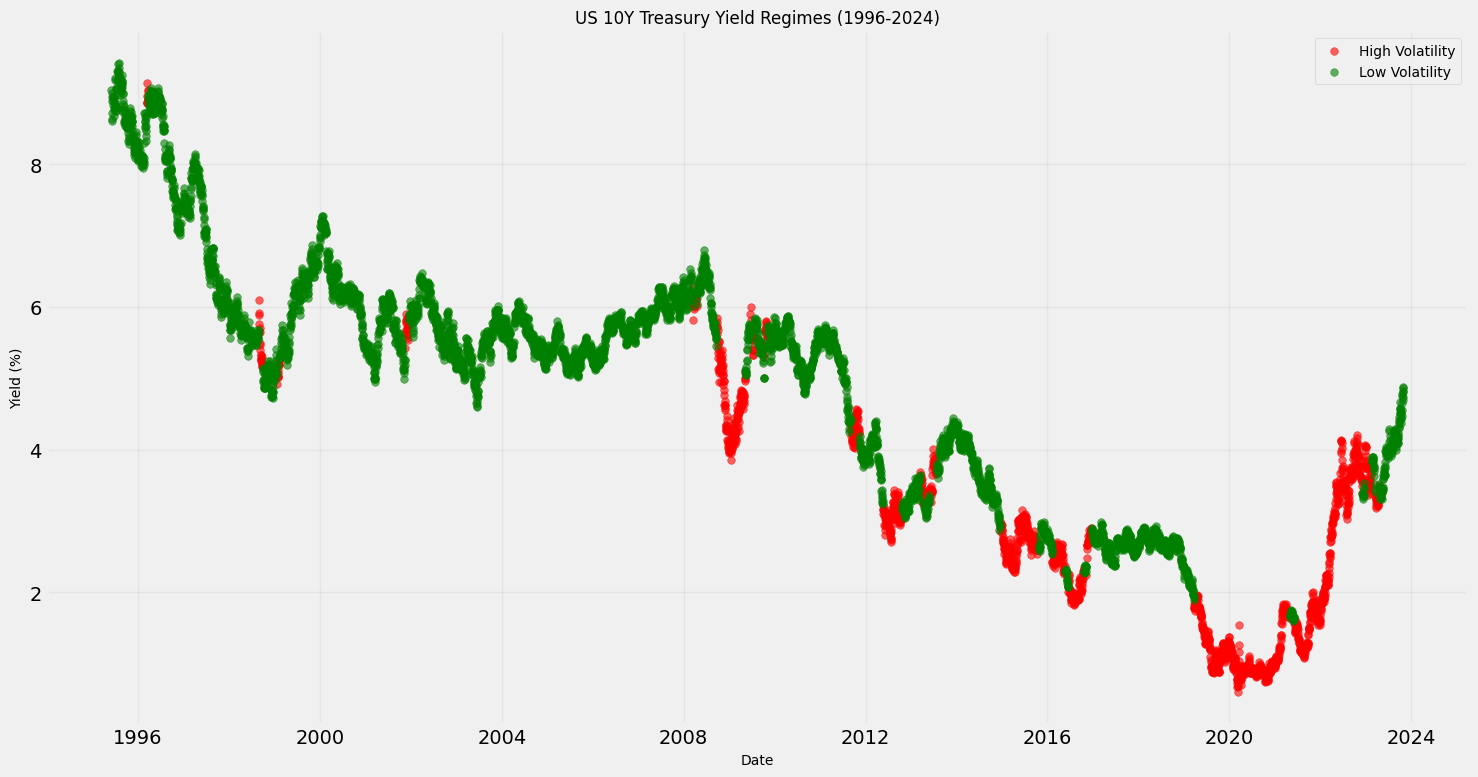

In [268]:
# plotting the regimes
plt.figure(figsize=(15, 8))

high_vol_mask = df_final_regime['vol_regime'] == 'High Volatility'
low_vol_mask = df_final_regime['vol_regime'] == 'Low Volatility'

plt.scatter(df_final_regime[high_vol_mask].index, 
           df_final_regime[high_vol_mask]['yield_10y'],
           color='red',
           s=30,
           label='High Volatility',
           alpha=0.6)

plt.scatter(df_final_regime[low_vol_mask].index,
           df_final_regime[low_vol_mask]['yield_10y'],
           color='green',
           s=30,
           label='Low Volatility',
           alpha=0.6)

plt.title('US 10Y Treasury Yield Regimes (1996-2024)', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Yield (%)', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

In [269]:
df_final_regime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7039 entries, 1995-06-01 to 2023-10-30
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RSI               7039 non-null   float64
 1   SMA_short         7039 non-null   float64
 2   SMA_long          7039 non-null   float64
 3   EMA_short         7039 non-null   float64
 4   EMA_long          7039 non-null   float64
 5   BB_upper          7039 non-null   float64
 6   BB_lower          7039 non-null   float64
 7   BB_width          7039 non-null   float64
 8   Ichimoku_Tenkan   7039 non-null   float64
 9   Ichimoku_Kijun    7039 non-null   float64
 10  Ichimoku_SenkouB  7039 non-null   float64
 11  fed_funds_rate    7039 non-null   float64
 12  yield_10y         7039 non-null   float64
 13  returns           7039 non-null   float64
 14  rolling_vol       7039 non-null   float64
 15  annualized_vol    7039 non-null   float64
 16  hidden_state      7039 n

# Now making Final predictions using Lightgbm and lasso for expanding window training data before 2019 Feb

In [273]:
# define features and target
features = ['RSI', 'SMA_short', 'SMA_long', 'EMA_short', 'BB_upper', 'BB_lower','BB_width', 'Ichimoku_Tenkan', 'Ichimoku_Kijun']
target = 'yield_10y'

In [274]:
# ensure no missing values in key columns
df_final_regime = df_final_regime.dropna(subset=features + [target])

In [275]:
# split into train and test before covid data
cutoff_date = pd.to_datetime("2019-02-01")
df_train = df_final_regime[df_final_regime.index < cutoff_date].copy()
df_test = df_final_regime[df_final_regime.index >= cutoff_date].copy()

In [276]:
# create custom expanding window splits
def create_expanding_window_splits(data, initial_train_size=0.3, step_size=365):
    total_size = len(data)
    initial_train_end = int(total_size * initial_train_size)
    
    splits = []
    for train_end in range(initial_train_end, len(data), step_size):
        if train_end + step_size > len(data):
            break
        train_idx = list(range(0, train_end))
        val_idx = list(range(train_end, min(train_end + step_size, len(data))))
        splits.append((train_idx, val_idx))
    
    return splits

In [277]:
# separate train data by regime
df_train_low = df_train[df_train['vol_regime'] == 'Low Volatility']
df_train_high = df_train[df_train['vol_regime'] == 'High Volatility']

In [278]:
# create train sets
X_train_low = df_train_low[features]
y_train_low = df_train_low[target]
X_train_high = df_train_high[features]
y_train_high = df_train_high[target]

In [279]:
# create expanding window splits for each regime
print('creating splits for low volatility regime...')
splits_low = create_expanding_window_splits(
    X_train_low, 
    initial_train_size=0.3, 
    step_size=365
)
print(f'number of splits for low vol regime: {len(splits_low)}')

print('creating splits for high volatility regime...')
splits_high = create_expanding_window_splits(
    X_train_high, 
    initial_train_size=0.3, 
    step_size=365
)
print(f'number of splits for high vol regime: {len(splits_high)}')

# validate we have enough splits
if len(splits_low) == 0 or len(splits_high) == 0:
    raise ValueError('not enough data to create splits. check initial_train_size and step_size')


creating splits for low volatility regime...
number of splits for low vol regime: 9
creating splits for high volatility regime...
number of splits for high vol regime: 1


In [280]:
# define parameter grids
lasso_param_grid = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

lgbm_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 50, 100]
}

In [281]:
# function to perform grid search with expanding window cv
def custom_grid_search(X, y, model, param_grid, splits, is_pipeline=True):
    best_score = float('inf')
    best_params = None
    best_model = None
    
    # create all parameter combinations
    param_combinations = []
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    from itertools import product
    for params in product(*values):
        param_combinations.append(dict(zip(keys, params)))
    
    for params in param_combinations:
        cv_scores = []
        for train_idx, val_idx in splits:
            # create a fresh model instance for each fold
            if is_pipeline:
                current_model = Pipeline([
                    ('scaler', StandardScaler()),
                    ('regressor', Lasso(max_iter=10000))
                ])
            else:
                current_model = LGBMRegressor(random_state=42)
            
            # set parameters
            current_model.set_params(**params)
            
            # fit and evaluate
            current_model.fit(X.iloc[train_idx], y.iloc[train_idx])
            val_pred = current_model.predict(X.iloc[val_idx])
            mse = mean_squared_error(y.iloc[val_idx], val_pred)
            cv_scores.append(mse)
        
        avg_score = np.mean(cv_scores)
        if avg_score < best_score:
            best_score = avg_score
            best_params = params
            
            # create and fit final model with best params
            if is_pipeline:
                best_model = Pipeline([
                    ('scaler', StandardScaler()),
                    ('regressor', Lasso(max_iter=10000))
                ])
            else:
                best_model = LGBMRegressor(random_state=42)
            
            best_model.set_params(**best_params)
            best_model.fit(X, y)
    
    return best_model, best_params, best_score

In [282]:
# train models for low volatility regime
print('training low volatility regime models...')
lasso_pipeline_low = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=10000))
])
best_lasso_low, best_lasso_params_low, _ = custom_grid_search(
    X_train_low, y_train_low, lasso_pipeline_low, lasso_param_grid, splits_low
)

lgbm_low = LGBMRegressor(random_state=42)
best_lgbm_low, best_lgbm_params_low, _ = custom_grid_search(
    X_train_low, y_train_low, lgbm_low, lgbm_param_grid, splits_low, False
)

training low volatility regime models...


In [283]:
# train models for high volatility regime
print('training high volatility regime models...')
lasso_pipeline_high = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=10000))
])
best_lasso_high, best_lasso_params_high, _ = custom_grid_search(
    X_train_high, y_train_high, lasso_pipeline_high, lasso_param_grid, splits_high
)

lgbm_high = LGBMRegressor(random_state=42)
best_lgbm_high, best_lgbm_params_high, _ = custom_grid_search(
    X_train_high, y_train_high, lgbm_high, lgbm_param_grid, splits_high, False
)

training high volatility regime models...


In [284]:
# make predictions on test set
df_test['pred_lasso'] = np.nan
df_test['pred_lgbm'] = np.nan

In [285]:
# predict using regime-specific models
for idx, row in df_test.iterrows():
    x_row = row[features].values.reshape(1, -1)
    
    if row['vol_regime'] == 'Low Volatility':
        df_test.loc[idx, 'pred_lasso'] = best_lasso_low.predict(x_row)[0]
        df_test.loc[idx, 'pred_lgbm'] = best_lgbm_low.predict(x_row)[0]
    else:
        df_test.loc[idx, 'pred_lasso'] = best_lasso_high.predict(x_row)[0]
        df_test.loc[idx, 'pred_lgbm'] = best_lgbm_high.predict(x_row)[0]

In [286]:
# evaluate results
print('\noverall test set metrics:')
print('lasso mse:', mean_squared_error(df_test[target], df_test['pred_lasso']))
print('lgbm mse:', mean_squared_error(df_test[target], df_test['pred_lgbm']))


overall test set metrics:
lasso mse: 0.0027862498638559874
lgbm mse: 0.37850452229202874


In [287]:
# evaluate by regime
df_test_low = df_test[df_test['vol_regime'] == 'Low Volatility']
df_test_high = df_test[df_test['vol_regime'] == 'High Volatility']

print('\nlow volatility regime metrics:')
print('lasso mse:', mean_squared_error(df_test_low[target], df_test_low['pred_lasso']))
print('lgbm mse:', mean_squared_error(df_test_low[target], df_test_low['pred_lgbm']))

print('\nhigh volatility regime metrics:')
print('lasso mse:', mean_squared_error(df_test_high[target], df_test_high['pred_lasso']))
print('lgbm mse:', mean_squared_error(df_test_high[target], df_test_high['pred_lgbm']))


low volatility regime metrics:
lasso mse: 0.0021478616364732465
lgbm mse: 0.04246902305419582

high volatility regime metrics:
lasso mse: 0.0029315472873900606
lgbm mse: 0.45498634034718954


In [288]:
# print best parameters
print('\nbest parameters:')
print('low volatility lasso:', best_lasso_params_low)
print('low volatility lgbm:', best_lgbm_params_low)
print('high volatility lasso:', best_lasso_params_high)
print('high volatility lgbm:', best_lgbm_params_high)


best parameters:
low volatility lasso: {'regressor__alpha': 0.0001}
low volatility lgbm: {'learning_rate': 0.05, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 20}
high volatility lasso: {'regressor__alpha': 0.01}
high volatility lgbm: {'learning_rate': 0.1, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 20}


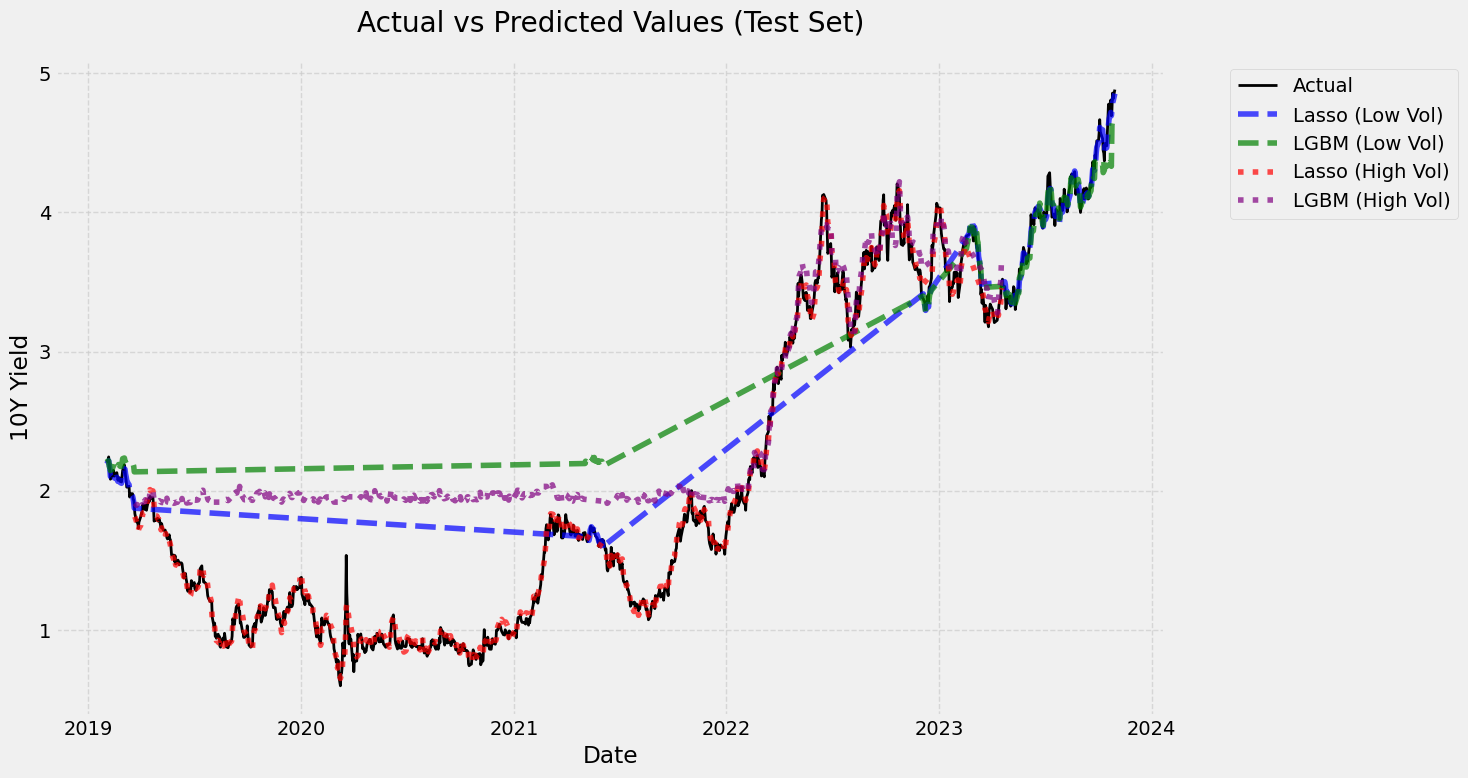

In [289]:
#plotting teh results
# create figure and axis
plt.figure(figsize=(15, 8))
plt.plot(df_test.index, df_test[target], label='Actual', color='black', linewidth=2)

# plot predictions for low volatility regime
mask_low = df_test['vol_regime'] == 'Low Volatility'
plt.plot(df_test[mask_low].index, df_test[mask_low]['pred_lasso'], 
         label='Lasso (Low Vol)', color='blue', linestyle='--', alpha=0.7)
plt.plot(df_test[mask_low].index, df_test[mask_low]['pred_lgbm'],
         label='LGBM (Low Vol)', color='green', linestyle='--', alpha=0.7)

# plot predictions for high volatility regime
mask_high = df_test['vol_regime'] == 'High Volatility'
plt.plot(df_test[mask_high].index, df_test[mask_high]['pred_lasso'],
         label='Lasso (High Vol)', color='red', linestyle=':', alpha=0.7)
plt.plot(df_test[mask_high].index, df_test[mask_high]['pred_lgbm'],
         label='LGBM (High Vol)', color='purple', linestyle=':', alpha=0.7)

# customize x-axis
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Actual vs Predicted Values (Test Set)', pad=20)
plt.xlabel('Date')
plt.ylabel('10Y Yield')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Here we can see that Lasso outperfoems lightgbm

## 5) Ichimoku Kinko Hyo Cloud strategy on predicted values

In [290]:
def calculate_ichimoku_cloud(df, tenkan_period=32, kijun_period=35, senkou_b_period=192):
    # calculate conversion line (tenkan-sen)
    high_tenkan = df['pred_lasso'].rolling(window=tenkan_period).max()
    low_tenkan = df['pred_lasso'].rolling(window=tenkan_period).min()
    df['tenkan_sen'] = (high_tenkan + low_tenkan) / 2
    
    # calculate base line (kijun-sen)
    high_kijun = df['pred_lasso'].rolling(window=kijun_period).max()
    low_kijun = df['pred_lasso'].rolling(window=kijun_period).min()
    df['kijun_sen'] = (high_kijun + low_kijun) / 2
    
    # calculate leading span a (senkou span a)
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(kijun_period)
    
    # calculate leading span b (senkou span b)
    high_senkou = df['pred_lasso'].rolling(window=senkou_b_period).max()
    low_senkou = df['pred_lasso'].rolling(window=senkou_b_period).min()
    df['senkou_span_b'] = ((high_senkou + low_senkou) / 2).shift(kijun_period)
    
    return df

In [291]:
def generate_signals(df):
    df['signal'] = 0  # 0: no signal, 1: buy, -1: sell
    
    for i in range(1, len(df)):
        # buy signal conditions
        if (df['pred_lasso'].iloc[i] > df['senkou_span_a'].iloc[i] and 
            df['pred_lasso'].iloc[i] > df['senkou_span_b'].iloc[i] and
            df['tenkan_sen'].iloc[i] > df['kijun_sen'].iloc[i] and
            df['tenkan_sen'].iloc[i-1] <= df['kijun_sen'].iloc[i-1]):
            df['signal'].iloc[i] = 1
            
        # sell signal conditions
        elif (df['pred_lasso'].iloc[i] < df['senkou_span_a'].iloc[i] and 
              df['pred_lasso'].iloc[i] < df['senkou_span_b'].iloc[i] and
              df['tenkan_sen'].iloc[i] < df['kijun_sen'].iloc[i] and
              df['tenkan_sen'].iloc[i-1] >= df['kijun_sen'].iloc[i-1]):
            df['signal'].iloc[i] = -1
            
    return df

In [292]:
def plot_signals_with_cloud(df_test):
    # calculate ichimoku cloud components
    df_test = calculate_ichimoku_cloud(df_test)
    
    # generate signals
    df_test = generate_signals(df_test)
    
    plt.figure(figsize=(20, 10))
    plt.plot(df_test.index, df_test['yield_10y'], label='Actual', color='black', linewidth=2)
    
    mask_low = df_test['vol_regime'] == 'Low Volatility'
    mask_high = df_test['vol_regime'] == 'High Volatility'
    
    plt.plot(df_test[mask_low].index, df_test[mask_low]['pred_lasso'], 
             label='Lasso (Low Vol)', color='blue', linestyle='--', alpha=0.7)
    plt.plot(df_test[mask_high].index, df_test[mask_high]['pred_lasso'],
             label='Lasso (High Vol)', color='red', linestyle='--', alpha=0.7)
    
    # plot ichimoku components
    plt.plot(df_test.index, df_test['tenkan_sen'], label='Tenkan-sen', color='green', alpha=0.5)
    plt.plot(df_test.index, df_test['kijun_sen'], label='Kijun-sen', color='red', alpha=0.5)
    plt.fill_between(df_test.index, df_test['senkou_span_a'], df_test['senkou_span_b'],
                     where=df_test['senkou_span_a'] >= df_test['senkou_span_b'],
                     color='lightgreen', alpha=0.3, label='Green Cloud')
    plt.fill_between(df_test.index, df_test['senkou_span_a'], df_test['senkou_span_b'],
                     where=df_test['senkou_span_a'] < df_test['senkou_span_b'],
                     color='lightcoral', alpha=0.3, label='Red Cloud')
    
    # plot buy/sell signals
    buy_signals = df_test[df_test['signal'] == 1]
    sell_signals = df_test[df_test['signal'] == -1]
    
    plt.scatter(buy_signals.index, buy_signals['pred_lasso'],
                color='green', marker='^', s=400, label='Buy Signal')
    plt.scatter(sell_signals.index, sell_signals['pred_lasso'],
                color='red', marker='v', s=400, label='Sell Signal')
    
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title('Yield Predictions with Ichimoku Cloud and Trading Signals', pad=20)
    plt.xlabel('Date')
    plt.ylabel('10Y Yield')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return df_test


trading signal summary:
number of buy signals: 25
number of sell signals: 6


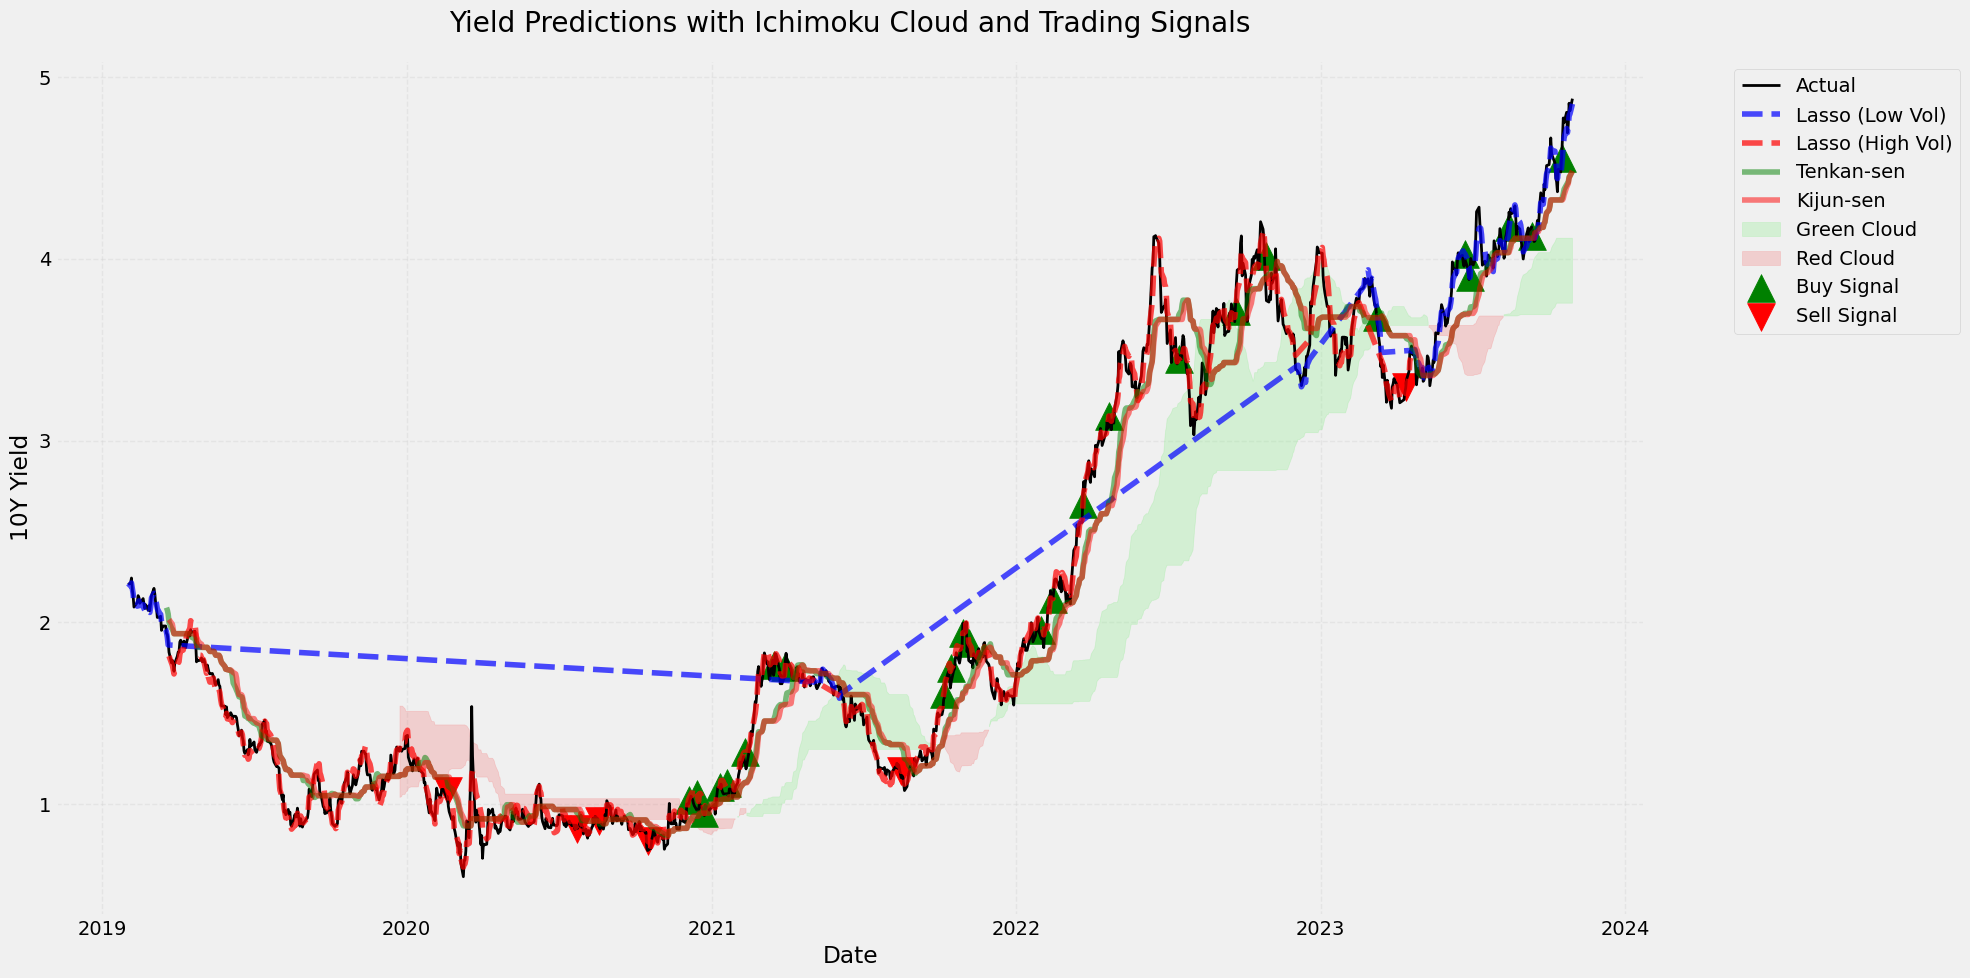

In [293]:
# generate and plot signals
df_test_with_signals = plot_signals_with_cloud(df_test.copy())

# display signal statistics
n_buy_signals = len(df_test_with_signals[df_test_with_signals['signal'] == 1])
n_sell_signals = len(df_test_with_signals[df_test_with_signals['signal'] == -1])

print(f"\ntrading signal summary:")
print(f"number of buy signals: {n_buy_signals}")
print(f"number of sell signals: {n_sell_signals}")

plt.show()

# Hypothesis tests for Signals


signal validation results:
----------------------------------------
total signals generated: 31
correct directional predictions: 17
directional accuracy: 0.5484
binomial test p-value: 0.7201

Low Volatility regime:
number of signals: 6
accuracy: 0.5000

High Volatility regime:
number of signals: 25
accuracy: 0.5600


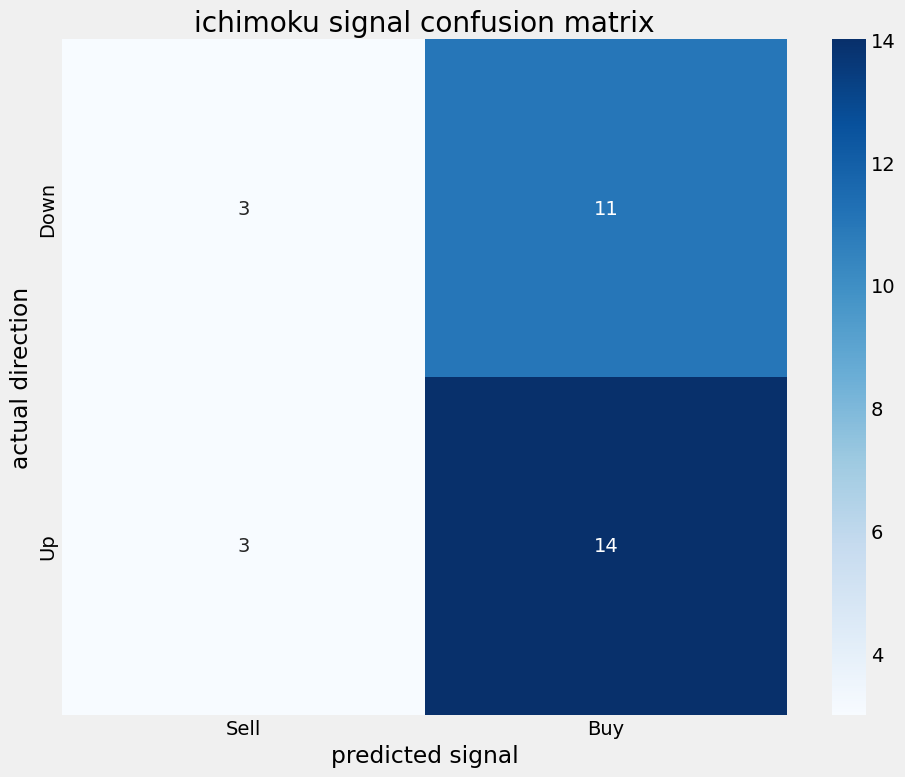


detailed metrics:
----------------------------------------
precision: 0.5600
recall: 0.8235
f1 score: 0.6667


In [294]:
def validate_ichimoku_signals(df):
    df = df.copy()
    df['next_yield'] = df['yield_10y'].shift(-1)
    df['actual_move'] = df['next_yield'] - df['yield_10y']
    
    df['actual_direction'] = np.where(df['actual_move'] > 0, 1, -1)
    
    signal_points = df[df['signal'] != 0].copy()
    
    conf_matrix = confusion_matrix(
        signal_points['actual_direction'],
        signal_points['signal']
    )
    
    total_signals = len(signal_points)
    correct_signals = np.sum(signal_points['actual_direction'] == signal_points['signal'])
    accuracy = correct_signals / total_signals if total_signals > 0 else 0
    
    binom_test = stats.binomtest(correct_signals, total_signals, p=0.5)
    
    print("\nsignal validation results:")
    print("-" * 40)
    print(f"total signals generated: {total_signals}")
    print(f"correct directional predictions: {correct_signals}")
    print(f"directional accuracy: {accuracy:.4f}")
    print(f"binomial test p-value: {binom_test.pvalue:.4f}")
    
    for regime in ['Low Volatility', 'High Volatility']:
        regime_signals = signal_points[signal_points['vol_regime'] == regime]
        if len(regime_signals) > 0:
            regime_correct = np.sum(regime_signals['actual_direction'] == regime_signals['signal'])
            regime_accuracy = regime_correct / len(regime_signals)
            print(f"\n{regime} regime:")
            print(f"number of signals: {len(regime_signals)}")
            print(f"accuracy: {regime_accuracy:.4f}")
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                xticklabels=['Sell', 'Buy'],
                yticklabels=['Down', 'Up'])
    plt.title('ichimoku signal confusion matrix')
    plt.xlabel('predicted signal')
    plt.ylabel('actual direction')
    plt.tight_layout()
    plt.show()
    true_pos = conf_matrix[1, 1]
    false_pos = conf_matrix[0, 1]
    true_neg = conf_matrix[0, 0]
    false_neg = conf_matrix[1, 0]
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print("\ndetailed metrics:")
    print("-" * 40)
    print(f"precision: {precision:.4f}")
    print(f"recall: {recall:.4f}")
    print(f"f1 score: {f1_score:.4f}")
    
    return {
        'accuracy': accuracy,
        'pvalue': binom_test.pvalue,
        'confusion_matrix': conf_matrix,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

results = validate_ichimoku_signals(df_test_with_signals)

# We have more accurately predicted in teh low vol regime but not so much in teh high vol regime and it is given so taht could be the case.  


amplitude analysis of signal vs non-signal points:
--------------------------------------------------
mean absolute move at signals: 0.042677
mean absolute move at random: 0.049323
mann-whitney u test p-value: 0.4304
effect size (cohen's d): -0.1706

buy vs sell signal analysis:
--------------------------------------------------
mean move after buy signals: 0.010000
mean move after sell signals: -0.001500
t-test between buy/sell moves p-value: 0.6608
std dev of buy moves: 0.059638
std dev of sell moves: 0.030226

regime-specific analysis:
--------------------------------------------------

Low Volatility:
number of signals: 6
mean absolute move: 0.064500
median absolute move: 0.065000
std dev of moves: 0.042645

High Volatility:
number of signals: 25
mean absolute move: 0.037440
median absolute move: 0.028000
std dev of moves: 0.032247


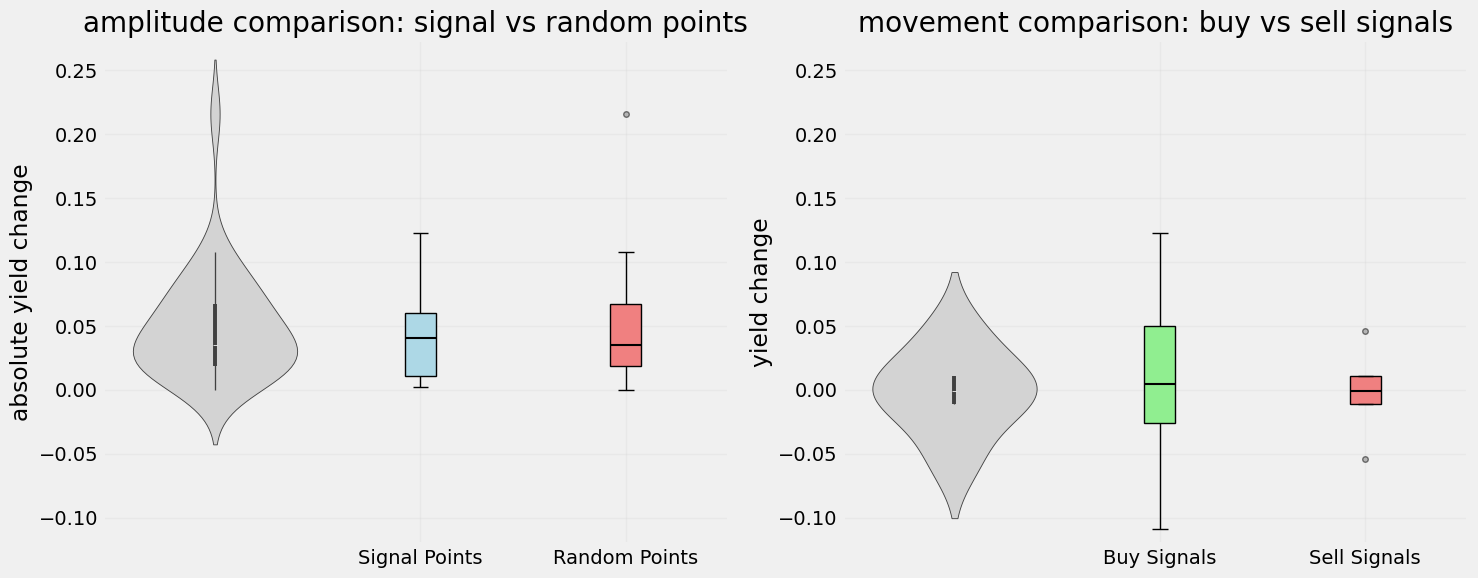

In [295]:
def test_signal_amplitude(df):
    df = df.copy()
    
    df['next_yield'] = df['yield_10y'].shift(-1)
    df['actual_move'] = df['next_yield'] - df['yield_10y']
    
    signal_points = df[df['signal'] != 0].copy()
    signal_moves = np.abs(signal_points['actual_move'])
    
    non_signal_points = df[df['signal'] == 0].copy()
    random_indices = np.random.choice(non_signal_points.index, 
                                    size=min(len(signal_moves), len(non_signal_points)), 
                                    replace=False)
    random_moves = np.abs(non_signal_points.loc[random_indices, 'actual_move'])
    
    print("\namplitude analysis of signal vs non-signal points:")
    print("-" * 50)
    
    mw_stat, mw_pvalue = stats.mannwhitneyu(signal_moves, random_moves, 
                                        alternative='two-sided')
    
    cohens_d = (np.mean(signal_moves) - np.mean(random_moves)) / np.sqrt(
        (np.var(signal_moves) + np.var(random_moves)) / 2
    )
    
    print(f"mean absolute move at signals: {np.mean(signal_moves):.6f}")
    print(f"mean absolute move at random: {np.mean(random_moves):.6f}")
    print(f"mann-whitney u test p-value: {mw_pvalue:.4f}")
    print(f"effect size (cohen's d): {cohens_d:.4f}")
    
    print("\nbuy vs sell signal analysis:")
    print("-" * 50)
    
    buy_moves = signal_points[signal_points['signal'] == 1]['actual_move']
    sell_moves = signal_points[signal_points['signal'] == -1]['actual_move']
    
    if len(buy_moves) > 0 and len(sell_moves) > 0:
        t_stat, t_pvalue = stats.ttest_ind(buy_moves, sell_moves)
        
        print(f"mean move after buy signals: {np.mean(buy_moves):.6f}")
        print(f"mean move after sell signals: {np.mean(sell_moves):.6f}")
        print(f"t-test between buy/sell moves p-value: {t_pvalue:.4f}")
        
        print(f"std dev of buy moves: {np.std(buy_moves):.6f}")
        print(f"std dev of sell moves: {np.std(sell_moves):.6f}")
    
    print("\nregime-specific analysis:")
    print("-" * 50)
    
    for regime in ['Low Volatility', 'High Volatility']:
        regime_signals = signal_points[signal_points['vol_regime'] == regime]
        regime_moves = np.abs(regime_signals['actual_move'])
        
        if len(regime_moves) > 0:
            print(f"\n{regime}:")
            print(f"number of signals: {len(regime_moves)}")
            print(f"mean absolute move: {np.mean(regime_moves):.6f}")
            print(f"median absolute move: {np.median(regime_moves):.6f}")
            print(f"std dev of moves: {np.std(regime_moves):.6f}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.violinplot(data=[signal_moves, random_moves], 
                  ax=ax1, 
                  inner='box',
                  color='lightgray')
    
    bp1 = ax1.boxplot([signal_moves, random_moves],
                     patch_artist=True,
                     medianprops=dict(color="black", linewidth=1.5),
                     flierprops=dict(marker='o', markerfacecolor='gray', 
                                   markersize=4, alpha=0.5))
    
    bp1['boxes'][0].set_facecolor('lightblue')
    bp1['boxes'][1].set_facecolor('lightcoral')
    
    ax1.set_xticklabels(['Signal Points', 'Random Points'])
    ax1.set_title('amplitude comparison: signal vs random points')
    ax1.set_ylabel('absolute yield change')
    ax1.grid(True, alpha=0.2)
    
    if len(buy_moves) > 0 and len(sell_moves) > 0:
        sns.violinplot(data=[buy_moves, sell_moves], 
                      ax=ax2, 
                      inner='box',
                      color='lightgray')
        
        bp2 = ax2.boxplot([buy_moves, sell_moves],
                         patch_artist=True,
                         medianprops=dict(color="black", linewidth=1.5),
                         flierprops=dict(marker='o', markerfacecolor='gray', 
                                       markersize=4, alpha=0.5))
        
        bp2['boxes'][0].set_facecolor('lightgreen')
        bp2['boxes'][1].set_facecolor('lightcoral')
        
        ax2.set_xticklabels(['Buy Signals', 'Sell Signals'])
        ax2.set_title('movement comparison: buy vs sell signals')
        ax2.set_ylabel('yield change')
        ax2.grid(True, alpha=0.2)
        
        y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
        y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
        ax1.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'signal_vs_random': {
            'signal_mean': np.mean(signal_moves),
            'random_mean': np.mean(random_moves),
            'mw_pvalue': mw_pvalue,
            'effect_size': cohens_d
        },
        'buy_vs_sell': {
            'buy_mean': np.mean(buy_moves),
            'sell_mean': np.mean(sell_moves),
            't_pvalue': t_pvalue if len(buy_moves) > 0 and len(sell_moves) > 0 else None,
            'buy_std': np.std(buy_moves),
            'sell_std': np.std(sell_moves)
        }
    }


amplitude_results = test_signal_amplitude(df_test_with_signals)

### 
* The Ichimoku strategy is not showing statistically significant predictive power for either movement direction or magnitude
* While there are some differences between signal and non-signal points, they're too small to be considered reliable
* The strategy appears to be generating more signals during high volatility periods, but these signals are actually less effective (smaller average moves)

### Based on these statistical results, this particular Ichimoku setup may  refinement as it's not showing strong predictive value:

* Adjust the parameters to potentially generate stronger signals
* Consider combining this with other indicators
* Look into why the Low Volatility signals, though fewer, seem to be more effective

## As for our rules teh rules the signals generation itself is out rule for trading teh 10 - year bond

# Ichimoku Cloud Trading Strategy Implementation

## Parameters
The strategy uses a modified Ichimoku Kinko Hyo with custom parameters:
* `Tenkan-sen = 32` (conversion line)
* `Kijun-sen = 35` (base line)
* `Senkou Span B = 192` (second component of the cloud)

## Signal Generation Rules

### Buy Signal ✅
```python
# Buy conditions
if (df['pred_lasso'].iloc[i] > df['senkou_span_a'].iloc[i] and 
    df['pred_lasso'].iloc[i] > df['senkou_span_b'].iloc[i] and
    df['tenkan_sen'].iloc[i] > df['kijun_sen'].iloc[i] and
    df['tenkan_sen'].iloc[i-1] <= df['kijun_sen'].iloc[i-1]):
    df['signal'].iloc[i] = 1
```
Signal generated when:
* Price > Cloud (both spans)
* Tenkan-sen crosses above Kijun-sen

### Sell Signal 🔻
```python
# Sell conditions
elif (df['pred_lasso'].iloc[i] < df['senkou_span_a'].iloc[i] and 
      df['pred_lasso'].iloc[i] < df['senkou_span_b'].iloc[i] and
      df['tenkan_sen'].iloc[i] < df['kijun_sen'].iloc[i] and
      df['tenkan_sen'].iloc[i-1] >= df['kijun_sen'].iloc[i-1]):
    df['signal'].iloc[i] = -1
```
Signal generated when:
* Price < Cloud (both spans)
* Tenkan-sen crosses below Kijun-sen

## Component Calculations
```python
# Tenkan-sen (Conversion Line)
high_tenkan = df['pred_lasso'].rolling(window=tenkan_period).max()
low_tenkan = df['pred_lasso'].rolling(window=tenkan_period).min()
df['tenkan_sen'] = (high_tenkan + low_tenkan) / 2

# Kijun-sen (Base Line)
high_kijun = df['pred_lasso'].rolling(window=kijun_period).max()
low_kijun = df['pred_lasso'].rolling(window=kijun_period).min()
df['kijun_sen'] = (high_kijun + low_kijun) / 2

# Senkou Span A
df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(kijun_period)

# Senkou Span B
high_senkou = df['pred_lasso'].rolling(window=senkou_b_period).max()
low_senkou = df['pred_lasso'].rolling(window=senkou_b_period).min()
df['senkou_span_b'] = ((high_senkou + low_senkou) / 2).shift(kijun_period)
```

## Important Notes
* Strategy operates on predicted values (`pred_lasso`) rather than actual price
* Two distinct volatility regimes are considered (High/Low)
* No signals generated when price is within the cloud
* The cloud (Kumo) is formed between Senkou Span A and B
* Forward shift of 35 periods (Kijun-sen length) is applied to cloud components

## 6) Assessing Overfit

### We have tried our best so that look ahead bias doesn't seeps into teh dataset. But by the looks of it with laaso regression a little overfitting is visible in test set. But as we do not have a true out of sample value set where teh model has not seen the values before. We cannot comment on overfitting

## 7) Need to implement on for Euro and UK bonds